# Descriptive (Spatial) Analytics

In [1]:
# TODO: TITLES, COMMENTS AND DESCRIPTIONS

Task: Analyze taxi demand patterns for the relevant one-year period and 
city (please check carefully which year your team has been allocated). Specifically show how these
patterns (start time, trip length, start and end location, price, average idle time between trips, and so 
on) for the given sample varies in different spatio-temporal resolution (i.e., census tract vs. varying
hexagon diameter and/or temporal bin sizes). Give possible reasons for the observed patterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import h3
import h3pandas
import geopandas as gpd
import seaborn as sns
from datetime import datetime
from time import mktime
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

In [2]:
file_path = "./data/"

## Temporal Analysis

In [3]:
taxi_hourly = pd.read_csv(f"{file_path}taxi_hourly_processed.csv")
taxi_4hourly = pd.read_csv(f"{file_path}taxi_4_hourly_processed.csv")
taxi_daily = pd.read_csv(f"{file_path}taxi_daily_processed.csv")

In [4]:
taxi_daily

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0           2758        1280.125091         6.296124        26.651613   
1           4178        1181.376257         6.279143        24.232432   
2           3682        1173.786257         7.609269        29.881953   
3           5719        1139.688757         5.436548        21.120481   
4           5208        1127.401498         4.959952        19.782800   
..           ...                ...              ...              ...   
360        10081        1057.591410         5.966888        26.213992   
361        10623        1055.791208         5.827724        24.412671   
362        11069        1059.185563         5.684680        23.336422   
363        11302        1102.140683         5.707205        23.411620   
364        11177         953.026572         5.478861        22.623700   

     start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0      0.890703      0.442350        10.338136  0.929808    0.435098   
1      1.795412      0.000000         3.926865  1.770373    0.000000   
2      0.184161      0.022271         4.619913  0.071643    0.026073   
3     -1.316041      0.000000         5.855211 -1.260469    0.000000   
4      0.412394      0.000000         3.953066  0.416726    0.000000   
..          ...           ...              ...       ...         ...   
360    4.073064      0.052475         9.246593  3.987216    0.047614   
361    2.436485      0.416455         7.541989  2.435213    0.410901   
362    0.702525      0.000000         6.961707  0.702241    0.000000   
363    2.314306      0.000000         3.868670  2.307747    0.000000   
364    4.180748      0.000000         5.394929  4.213849    0.000000   

     end_windspeed  
0        10.332698  
1         3.927602  
2         4.663781  
3         5.884635  
4         3.847389  
..             ...  
360       9.291094  
361       7.462087  
362       6.938422  
363       3.924326  
364       5.498641  

[365 rows x 10 columns]

### General Stats

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

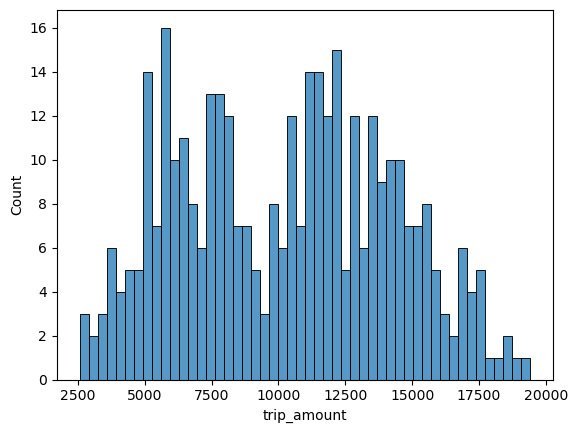

In [5]:
sns.histplot(data=taxi_daily, x="trip_amount", bins=50)

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

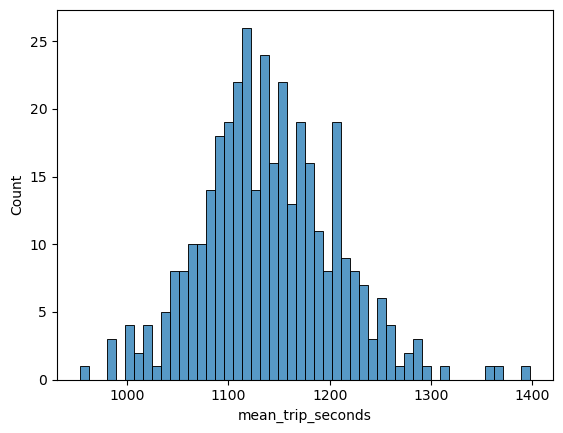

In [6]:
sns.histplot(data=taxi_daily, x="mean_trip_seconds", bins=50)

<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

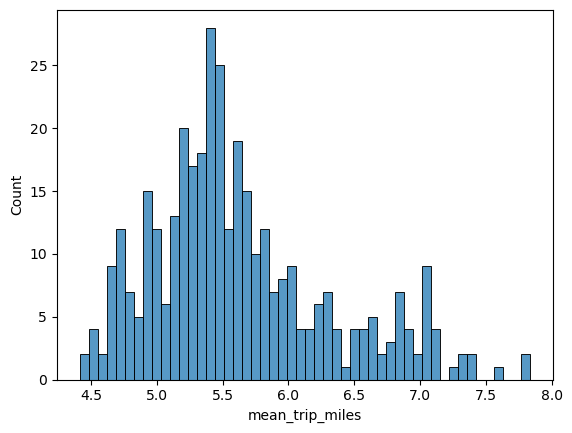

In [7]:
sns.histplot(data=taxi_daily, x="mean_trip_miles", bins=50)

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

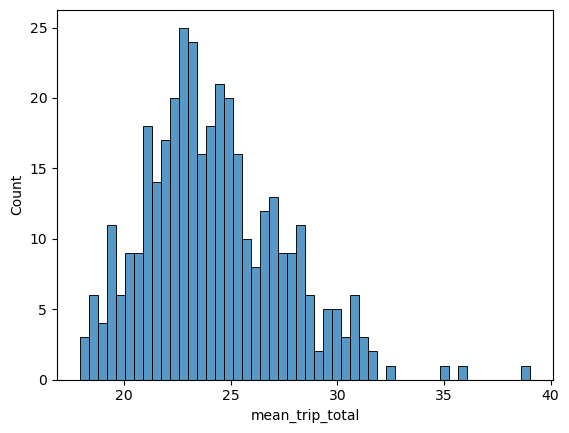

In [8]:
sns.histplot(data=taxi_daily, x="mean_trip_total", bins=50)

<AxesSubplot: xlabel='start_temp', ylabel='Count'>

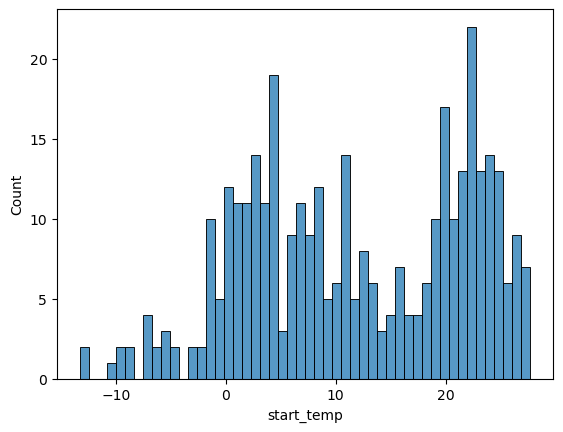

In [9]:
sns.histplot(data=taxi_daily, x="start_temp", bins=50)

<AxesSubplot: xlabel='start_precip', ylabel='Count'>

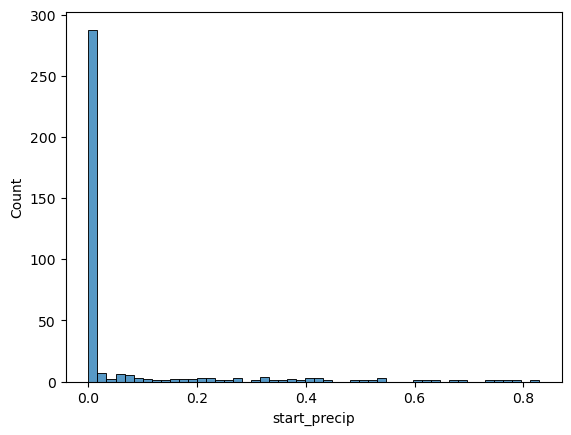

In [10]:
sns.histplot(data=taxi_daily, x="start_precip", bins=50)

### Daily Trends

<AxesSubplot: ylabel='trip_amount'>

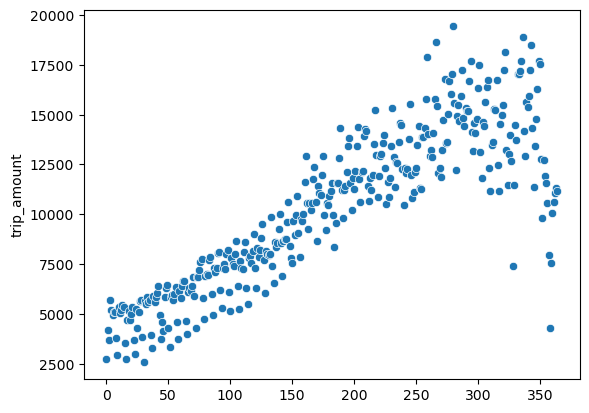

In [11]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount")

<AxesSubplot: ylabel='trip_amount'>

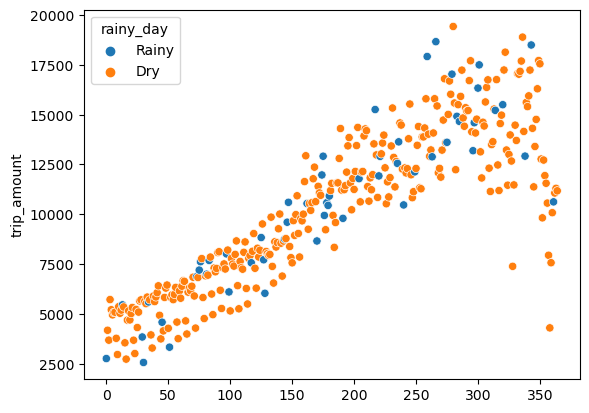

In [12]:
taxi_daily['rainy_day'] = (taxi_daily['start_precip'] >= 0.1).map({False: "Dry", True: "Rainy"})
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="rainy_day")

<AxesSubplot: ylabel='trip_amount'>

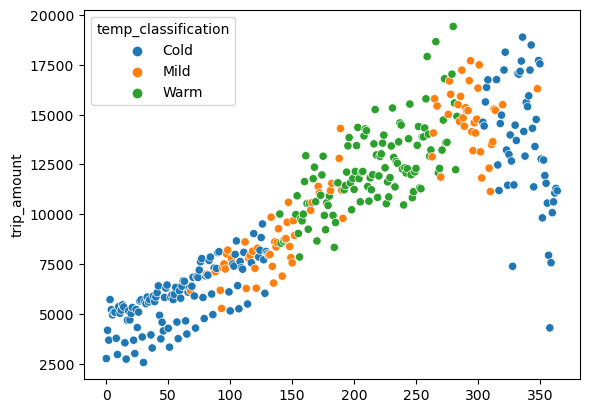

In [13]:
taxi_daily['temp_classification'] = taxi_daily["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="temp_classification")

<AxesSubplot: ylabel='start_temp'>

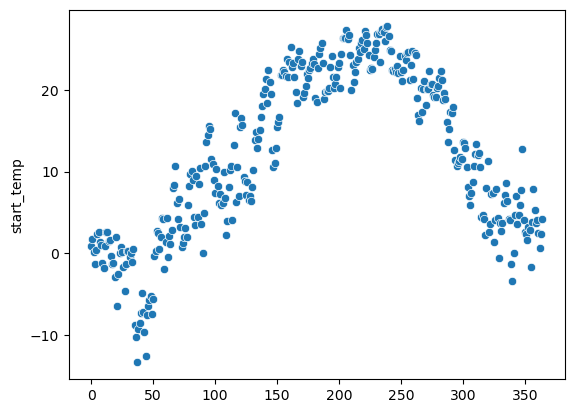

In [14]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="start_temp")

<AxesSubplot: ylabel='mean_trip_seconds'>

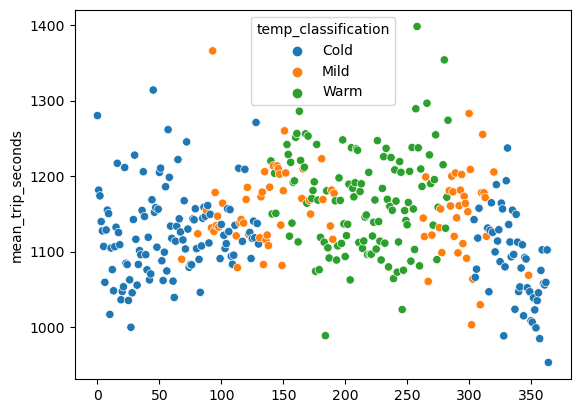

In [15]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="mean_trip_seconds", hue="temp_classification")

### Inner-Day Trends

In [16]:
taxi_4hourly

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0             228        1433.236842         4.697544        18.226140   
1             158         950.120253         5.815570        20.895316   
2             440        1054.975000         5.856864        21.924727   
3             770        1174.900000         5.640468        30.101013   
4             672        1353.471726         6.558080        27.010923   
...           ...                ...              ...              ...   
2185          509         945.163065         6.704617        25.400393   
2186         1814         968.095369         5.858104        22.453870   
2187         2984         997.779826         5.106438        21.373097   
2188         3043         955.385475         5.450654        21.948656   
2189         2044         865.197652         5.214026        23.158390   

      start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0      -1.284868      0.000000         6.950789 -1.242982    0.004386   
1      -0.424304      0.000000         9.201139 -0.351835    0.000000   
2       0.196000      0.318182        10.717455  0.266523    0.402273   
3       1.219013      1.000000        11.251234  1.264286    0.920779   
4       1.535967      0.232143        11.080551  1.522664    0.306548   
...          ...           ...              ...       ...         ...   
2185    0.227662      0.000000         2.082731  0.331788    0.000000   
2186    2.828980      0.000000         4.222690  3.062624    0.000000   
2187    4.960747      0.000000         5.527215  5.005245    0.000000   
2188    5.433874      0.000000         3.499734  5.427276    0.000000   
2189    4.577206      0.000000         9.352270  4.489095    0.000000   

      end_windspeed  
0          7.075482  
1          9.411392  
2         10.765386  
3         11.291857  
4         10.817173  
...             ...  
2185       2.135874  
2186       4.408572  
2187       5.560409  
2188       3.601410  
2189       9.622109  

[2190 rows x 10 columns]

In [17]:
taxi_4hourly["start_hour"] = taxi_4hourly.index.map(lambda x: (x % 6) * 4)
taxi_4hourly.head(10)

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0          228        1433.236842         4.697544        18.226140   
1          158         950.120253         5.815570        20.895316   
2          440        1054.975000         5.856864        21.924727   
3          770        1174.900000         5.640468        30.101013   
4          672        1353.471726         6.558080        27.010923   
5          490        1582.230612         8.260408        30.759449   
6          158        1120.658228         6.911139        27.320570   
7          146         939.438356         6.239932        21.629178   
8          774        1078.405685         5.733928        21.125478   
9         1346        1194.924963         5.858886        22.823187   

   start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0   -1.284868      0.000000         6.950789 -1.242982    0.004386   
1   -0.424304      0.000000         9.201139 -0.351835    0.000000   
2    0.196000      0.318182        10.717455  0.266523    0.402273   
3    1.219013      1.000000        11.251234  1.264286    0.920779   
4    1.535967      0.232143        11.080551  1.522664    0.306548   
5    1.550000      0.314286         9.487265  1.611020    0.218367   
6    1.953608      0.000000         9.253291  1.894494    0.000000   
7    1.379110      0.000000         4.988562  1.494795    0.000000   
8    2.251240      0.000000         3.237946  2.269083    0.000000   
9    2.201909      0.000000         2.915691  2.138759    0.000000   

   end_windspeed  start_hour  
0       7.075482           0  
1       9.411392           4  
2      10.765386           8  
3      11.291857          12  
4      10.817173          16  
5       9.585163          20  
6       8.864620           0  
7       4.891918           4  
8       3.085103           8  
9       3.063254          12

In [18]:
taxi_4hourly["time_of_day"] = taxi_4hourly["start_hour"].map(lambda x: "Morning" if x == 8  else "Noon" if x == 12 else "Afternoon" if x == 16 else "Evening" if x == 20 else "Night" if x == 0 else "Early Morning")
taxi_4hourly

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0             228        1433.236842         4.697544        18.226140   
1             158         950.120253         5.815570        20.895316   
2             440        1054.975000         5.856864        21.924727   
3             770        1174.900000         5.640468        30.101013   
4             672        1353.471726         6.558080        27.010923   
...           ...                ...              ...              ...   
2185          509         945.163065         6.704617        25.400393   
2186         1814         968.095369         5.858104        22.453870   
2187         2984         997.779826         5.106438        21.373097   
2188         3043         955.385475         5.450654        21.948656   
2189         2044         865.197652         5.214026        23.158390   

      start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0      -1.284868      0.000000         6.950789 -1.242982    0.004386   
1      -0.424304      0.000000         9.201139 -0.351835    0.000000   
2       0.196000      0.318182        10.717455  0.266523    0.402273   
3       1.219013      1.000000        11.251234  1.264286    0.920779   
4       1.535967      0.232143        11.080551  1.522664    0.306548   
...          ...           ...              ...       ...         ...   
2185    0.227662      0.000000         2.082731  0.331788    0.000000   
2186    2.828980      0.000000         4.222690  3.062624    0.000000   
2187    4.960747      0.000000         5.527215  5.005245    0.000000   
2188    5.433874      0.000000         3.499734  5.427276    0.000000   
2189    4.577206      0.000000         9.352270  4.489095    0.000000   

      end_windspeed  start_hour    time_of_day  
0          7.075482           0          Night  
1          9.411392           4  Early Morning  
2         10.765386           8        Morning  
3         11.291857          12           Noon  
4         10.817173          16      Afternoon  
...             ...         ...            ...  
2185       2.135874           4  Early Morning  
2186       4.408572           8        Morning  
2187       5.560409          12           Noon  
2188       3.601410          16      Afternoon  
2189       9.622109          20        Evening  

[2190 rows x 12 columns]

<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

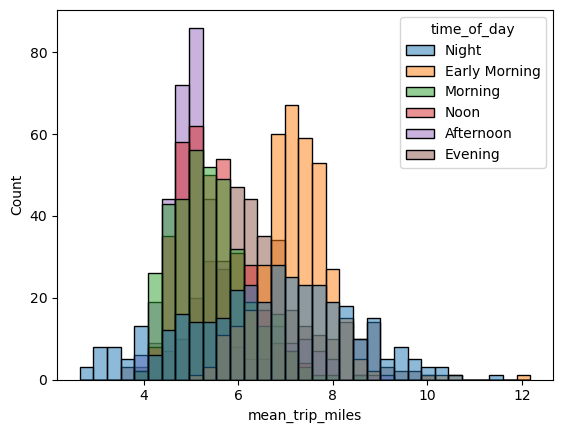

In [19]:
sns.histplot(data=taxi_4hourly, x="mean_trip_miles", hue="time_of_day")

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

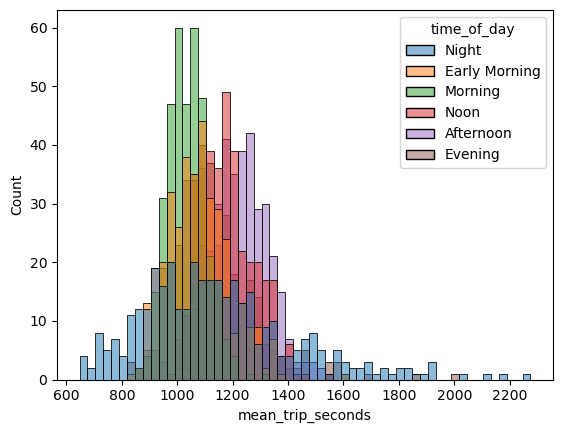

In [20]:
sns.histplot(data=taxi_4hourly, x="mean_trip_seconds", hue="time_of_day")

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

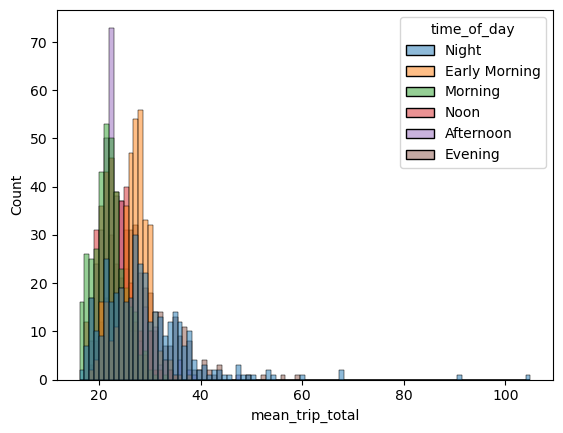

In [21]:
sns.histplot(data=taxi_4hourly, x="mean_trip_total", hue="time_of_day")

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

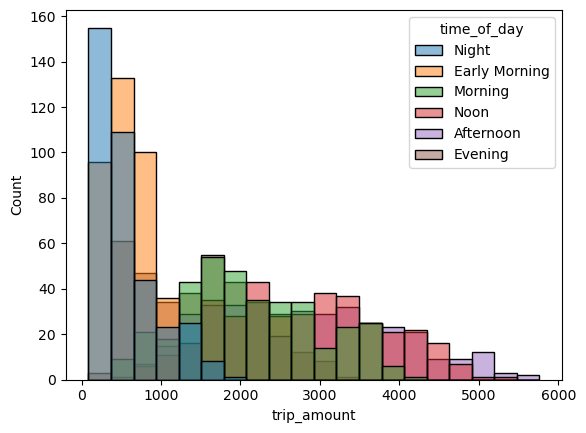

In [22]:
sns.histplot(data=taxi_4hourly, x="trip_amount", hue="time_of_day")

### Hourly Trends

In [23]:
taxi_hourly["start_hour"] = taxi_hourly.index.map(lambda x: x % 24)
taxi_hourly_agg = taxi_hourly.groupby("start_hour").agg({"trip_amount" : "sum", "mean_trip_seconds" : "mean", "mean_trip_miles" : "mean", "mean_trip_total" : "mean", "start_temp" : "mean", "start_precip" : "mean", "start_windspeed" : "mean"})
taxi_hourly_agg

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
start_hour                                                                     
0                 76744        1159.891392         6.836022        30.287541   
1                 55535        1203.384321         6.611098        30.104472   
2                 35425        1090.898678         5.958808        26.245407   
3                 24069        1016.987829         6.509225        25.590872   
4                 21396        1022.874228         7.910807        29.093054   
5                 32170        1095.611553         8.299762        29.798368   
6                 56309        1075.888945         7.660844        28.210895   
7                 99505        1100.268393         6.748118        25.498658   
8                153067        1042.784437         5.763000        22.784386   
9                184351        1005.320277         5.371618        21.888502   
10               208540        1025.218530         5.420639        22.047533   
11               229346        1055.306374         5.236469        21.696389   
12               243265        1100.689330         5.365540        22.671623   
13               254737        1168.263063         5.608841        23.641506   
14               258840        1200.469006         5.495317        23.434256   
15               261675        1243.805674         5.253664        23.059843   
16               265590        1265.061792         5.232537        23.054421   
17               269857        1264.351801         5.262615        23.475175   
18               260316        1215.715310         5.249551        23.941766   
19               224272        1160.908921         5.696321        26.080607   
20               178918        1164.548603         6.362118        27.596722   
21               143377        1128.263516         6.482113        28.120328   
22               117077        1092.759897         6.386896        27.924686   
23                97664        1097.847451         6.642372        29.322952   

            start_temp  start_precip  start_windspeed  
start_hour                                             
0            10.015726      0.054795         7.417397  
1             9.830822      0.052055         7.300027  
2             9.634329      0.041096         7.180356  
3             9.452575      0.043836         7.065205  
4             9.296466      0.035616         6.949644  
5             9.312000      0.041096         6.838274  
6             9.574110      0.057534         6.694082  
7            10.096630      0.043836         6.596548  
8            10.880082      0.046575         6.667507  
9            11.624548      0.046575         6.730630  
10           12.277151      0.046575         6.735315  
11           12.805233      0.046575         6.770438  
12           13.177918      0.057534         6.842630  
13           13.391178      0.060274         6.936904  
14           13.435945      0.057534         7.005671  
15           13.273918      0.065753         7.069644  
16           12.837425      0.071233         7.137479  
17           12.244247      0.068493         7.254493  
18           11.643562      0.068493         7.374548  
19           11.186247      0.068493         7.487589  
20           10.891836      0.076712         7.531726  
21           10.655425      0.073973         7.582767  
22           10.434164      0.071233         7.551288  
23           10.222466      0.065753         7.494548

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

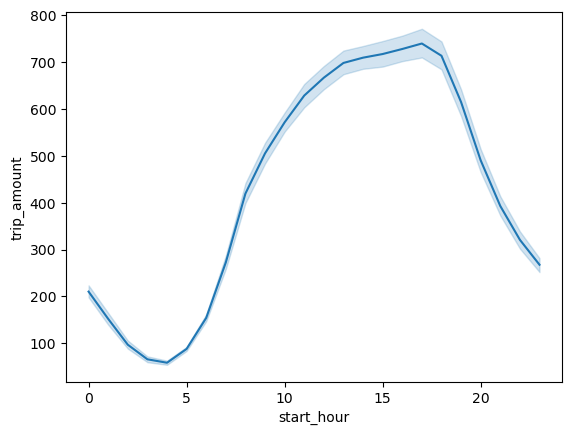

In [24]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount")

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_seconds'>

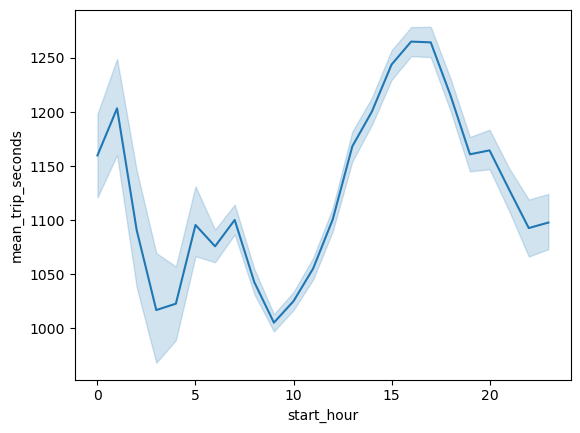

In [25]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_seconds")

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_total'>

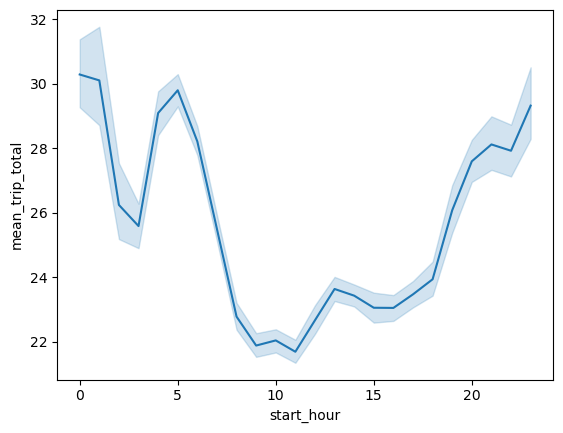

In [26]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_total")

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

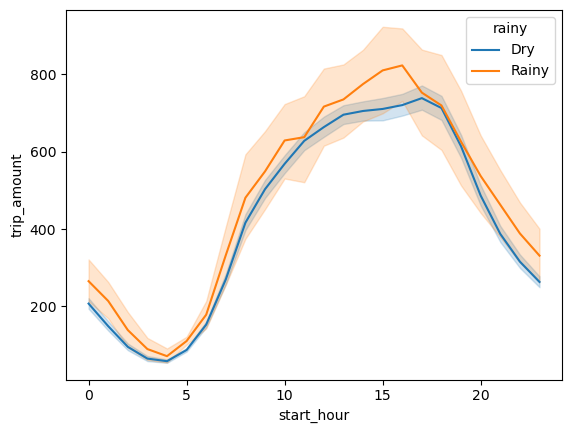

In [27]:
taxi_hourly['rainy'] = taxi_hourly["start_precip"].map(lambda x: "Rainy" if x > 0.5 else "Dry")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="rainy")

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

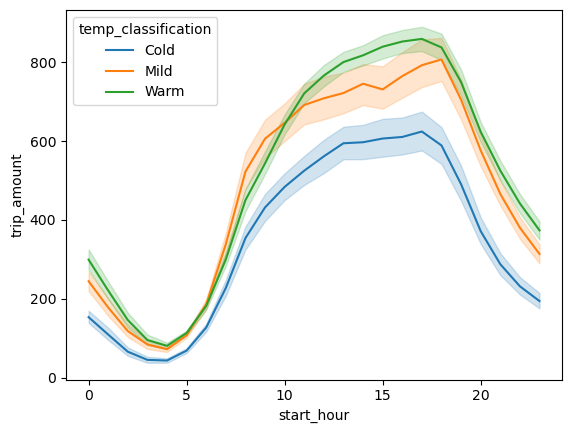

In [28]:
taxi_hourly['temp_classification'] = taxi_hourly["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="temp_classification")

## Spatial Analysis

In [29]:
taxi_by_census_tract = pd.read_csv(f"{file_path}taxi_by_census_tract.csv")
taxi_by_community_area = pd.read_csv(f"{file_path}taxi_by_community_area.csv")
taxi_by_h3_6 = pd.read_csv(f"{file_path}taxi_by_h3_6.csv")
taxi_by_h3_7 = pd.read_csv(f"{file_path}taxi_by_h3_7.csv")
taxi_by_h3_8 = pd.read_csv(f"{file_path}taxi_by_h3_8.csv")

In [30]:
taxi_by_census_tract['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_census_tract['geometry'])
taxi_by_census_tract_gpd = gpd.GeoDataFrame(taxi_by_census_tract, geometry="geometry")
taxi_by_community_area['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_community_area['geometry'])
taxi_by_community_area_gpd = gpd.GeoDataFrame(taxi_by_community_area, geometry="geometry")
taxi_h3_6_gpd = taxi_by_h3_6.set_index("h3_6_pickup").h3.h3_to_geo_boundary()
taxi_h3_7_gpd = taxi_by_h3_7.set_index("h3_7_pickup").h3.h3_to_geo_boundary()
taxi_h3_8_gpd = taxi_by_h3_8.set_index("h3_8_pickup").h3.h3_to_geo_boundary()
taxi_h3_6_gpd

trip_amount_pickup  mean_trip_seconds  mean_trip_miles  \
h3_6_pickup                                                               
862664197ffffff               11080        1448.481227         9.364503   
8626641b7ffffff                3066        1788.079256         8.357955   
862664527ffffff              125282        1649.224653        10.205765   
86266452fffffff                5777        2055.382205         6.949439   
862664567ffffff               33336        1390.357961         9.334279   
86266456fffffff                3363        1417.658638        10.898814   
862664577ffffff                 715        1564.504895         6.697776   
862664c17ffffff              230778         980.908579         3.468718   
862664c1fffffff             1515619         787.672578         3.109567   
862664c87ffffff               14307        1629.019501         7.959421   
862664c8fffffff                8515        1642.875984         7.101893   
862664ca7ffffff               88611        1228.270869         4.325785   
862664cafffffff              397938         902.564626         3.507207   
862664cb7ffffff               20747        1444.752350         4.452647   
862664cc7ffffff              130498        1291.421815         5.925023   
862664ccfffffff               54040        1467.680959         7.445430   
862664cd7ffffff               19678        1646.487550         7.017071   
862664cdfffffff               22689        1537.223192         7.869880   
862664ce7ffffff               35870        1222.124422         5.472164   
862664cefffffff               33194        1473.883834         7.267563   
862664cf7ffffff               82694        1140.993083         5.356186   
862664d8fffffff              229230        1218.925311         4.609768   
862664d9fffffff               26166        1373.814798         5.268046   
862759347ffffff              531243        1847.597999        12.461665   
86275936fffffff               12434        1454.113399         7.170364   

                 mean_trip_total  start_temp  start_precip  start_windspeed  \
h3_6_pickup                                                                   
862664197ffffff        30.112727   11.849060      0.055866         7.064433   
8626641b7ffffff        29.419416   12.557968      0.063927         7.075838   
862664527ffffff        48.307626   14.657493      0.067456         6.957620   
86266452fffffff        26.648717   12.836879      0.054873         7.019411   
862664567ffffff        29.205332   12.456111      0.052286         6.963084   
86266456fffffff        32.374671   12.904213      0.059471         7.008201   
862664577ffffff        29.148154   13.008713      0.064336         7.118993   
862664c17ffffff        17.140819   13.844397      0.066198         7.048221   
862664c1fffffff        15.698313   14.336133      0.069789         7.074435   
862664c87ffffff        27.996709   11.633953      0.054309         7.102900   
862664c8fffffff        25.720171   12.296491      0.055784         7.113188   
862664ca7ffffff        18.841547   12.657105      0.057070         7.011940   
862664cafffffff        16.681010   13.650951      0.066920         7.017452   
862664cb7ffffff        20.408603   11.545803      0.050610         7.027888   
862664cc7ffffff        23.147009   12.553886      0.056821         7.016643   
862664ccfffffff        26.850512   12.229465      0.052609         7.022834   
862664cd7ffffff        26.350897   11.518424      0.053257         7.115496   
862664cdfffffff        26.734998   11.934299      0.051258         7.013841   
862664ce7ffffff        22.767321   12.463463      0.053248         6.993347   
862664cefffffff        25.475141   12.229137      0.053594         7.004156   
862664cf7ffffff        21.831168   12.582602      0.054974         7.015487   
862664d8fffffff        18.355058   12.369130      0.057693         7.038117   
862664d9fffffff        20.912374   11.659287      0.055492         7.076188   
862759347ffffff 

In [175]:
import matplotlib.colors as colors
def plot_gpd(gpd, column, label, has_two_slope = False, color_scheme = 'coolwarm', show_legend=True):
    if has_two_slope: 
        return gpd.plot(legend=show_legend, column=column, figsize=(10, 10), norm=colors.TwoSlopeNorm(vmin=gpd[column].min(), vcenter=0, vmax=gpd[column].max()), cmap=color_scheme, legend_kwds = {'label': label})
    else:
        return gpd.plot(legend=show_legend, column=column, figsize=(10, 10), cmap=color_scheme, legend_kwds = {'label': label})

### Trips started

<AxesSubplot: >

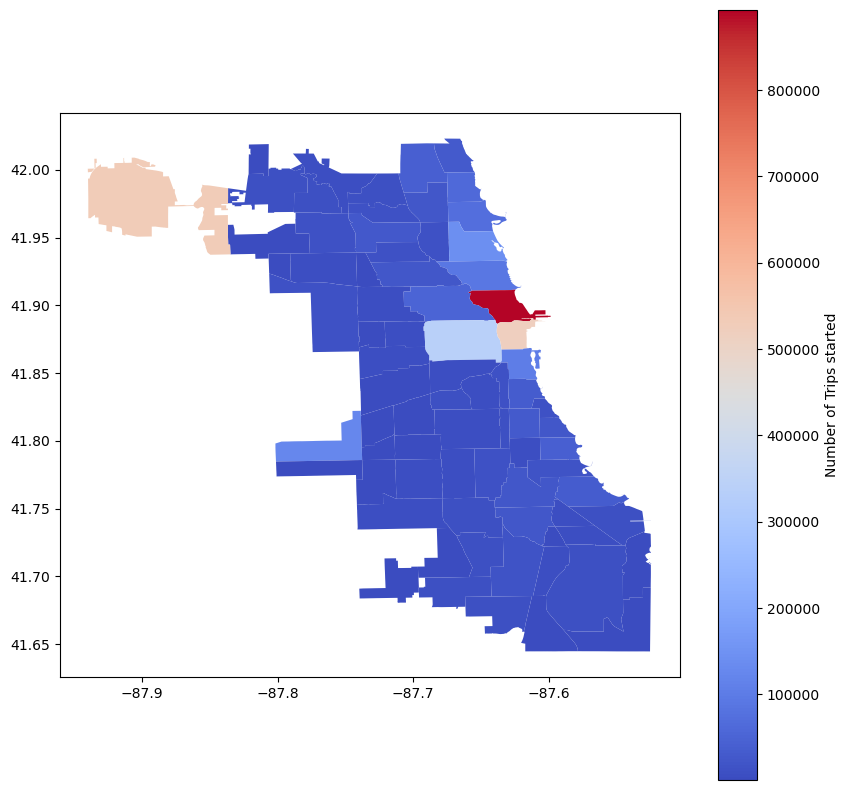

In [176]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

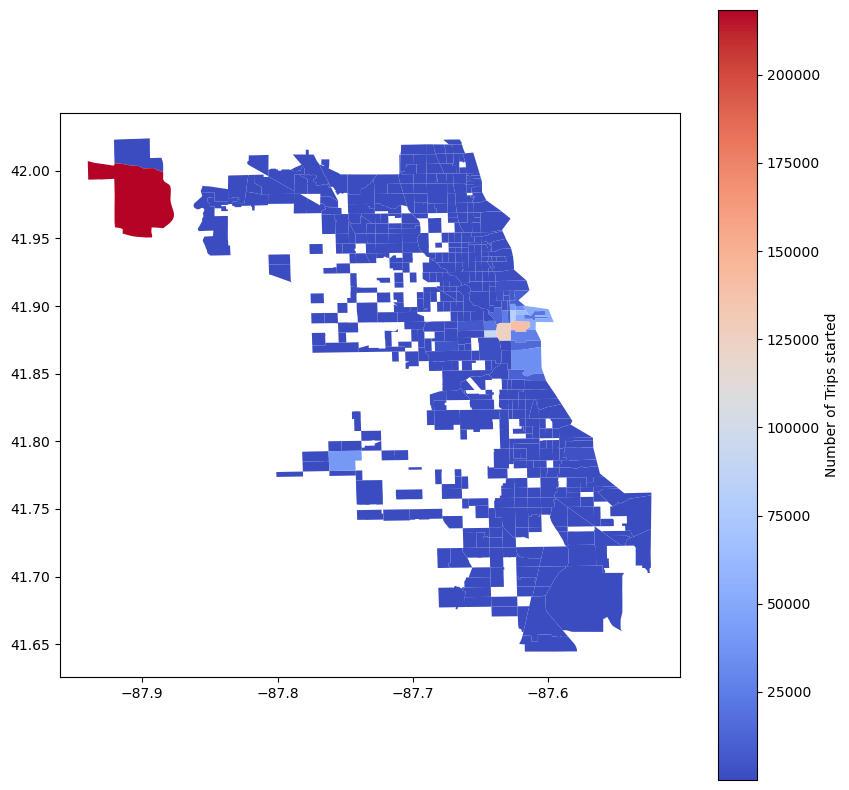

In [177]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

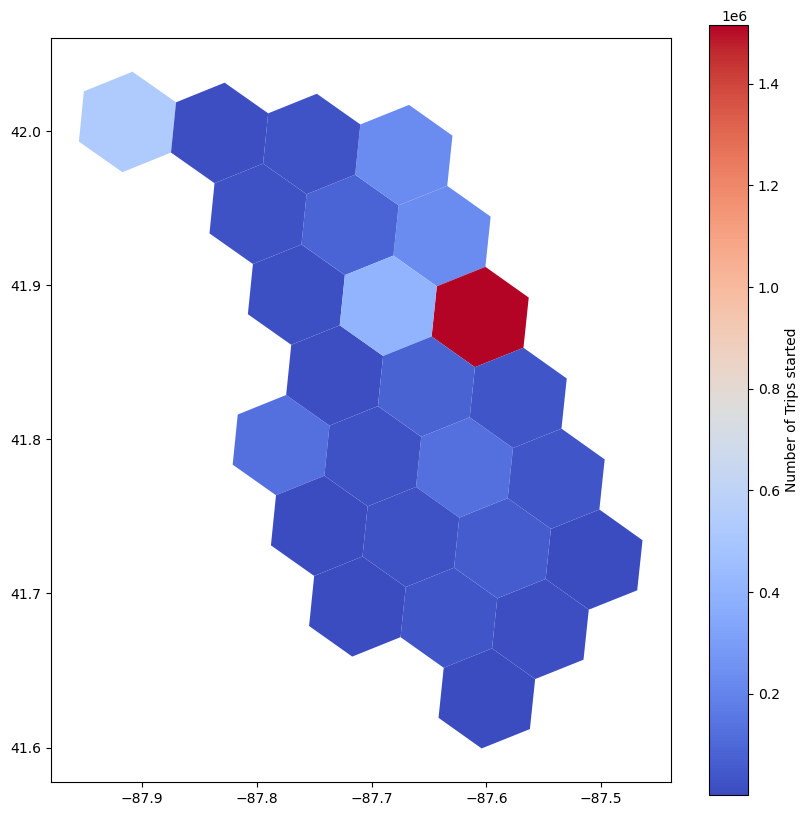

In [178]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

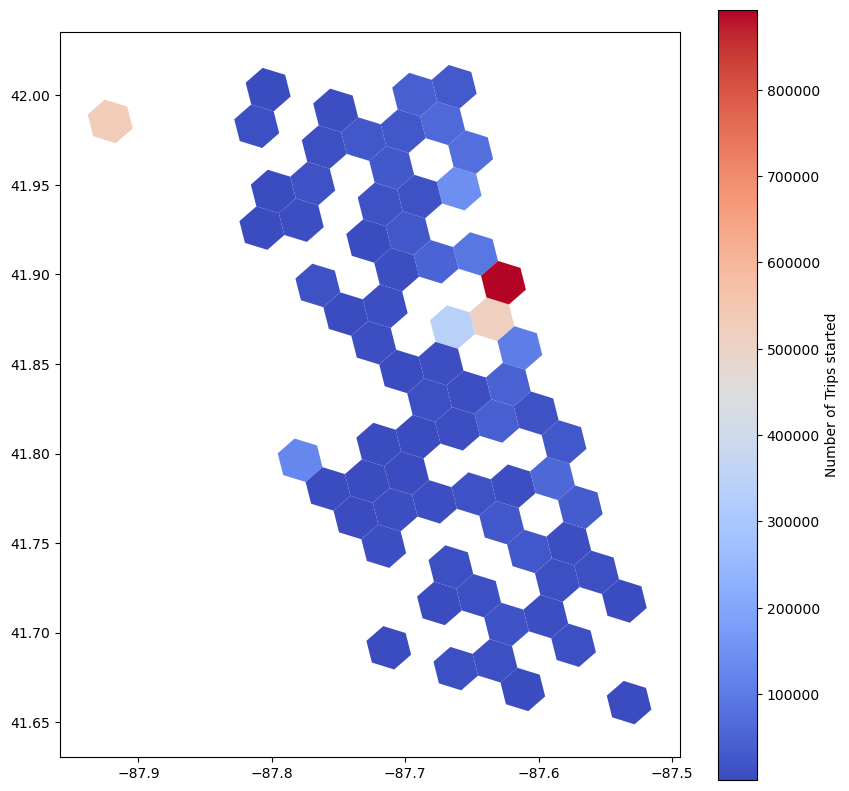

In [179]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

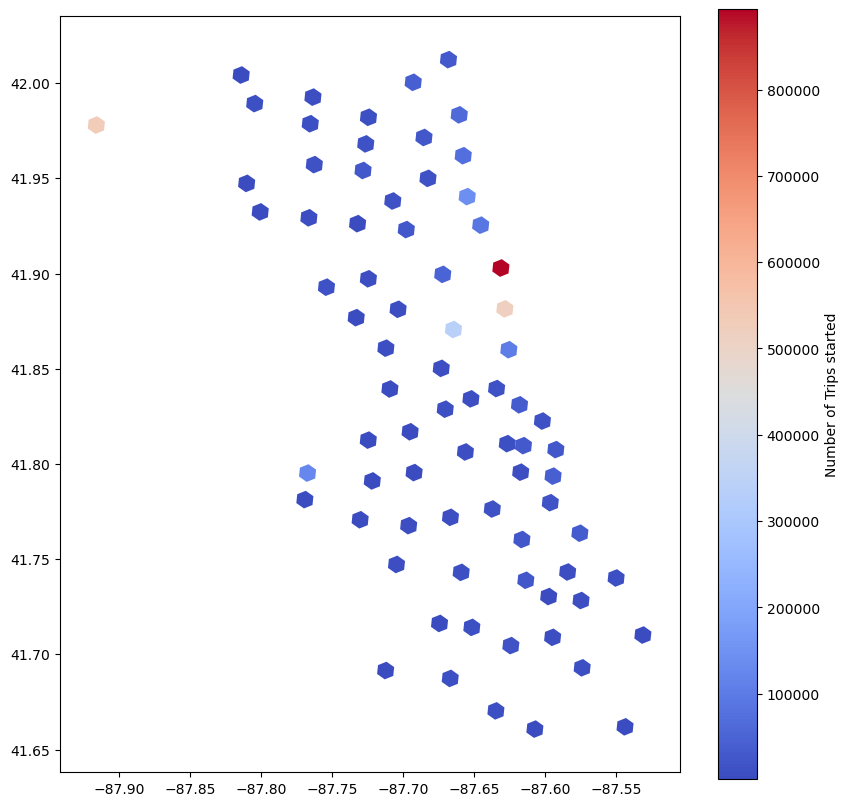

In [180]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_pickup", "Number of Trips started", False)

### Trips ended

<AxesSubplot: >

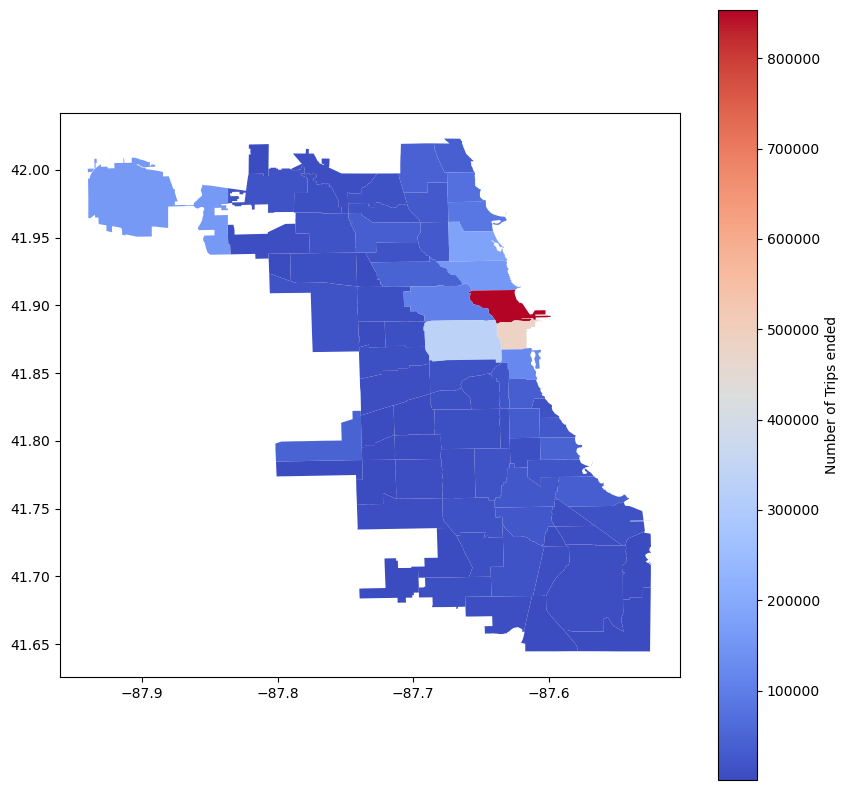

In [181]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

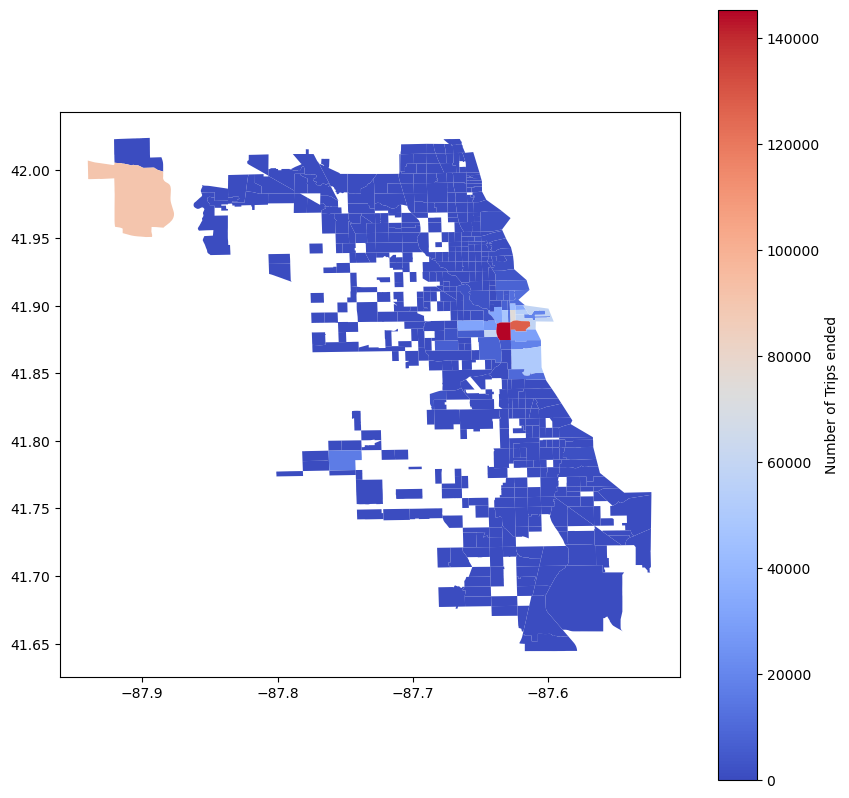

In [182]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

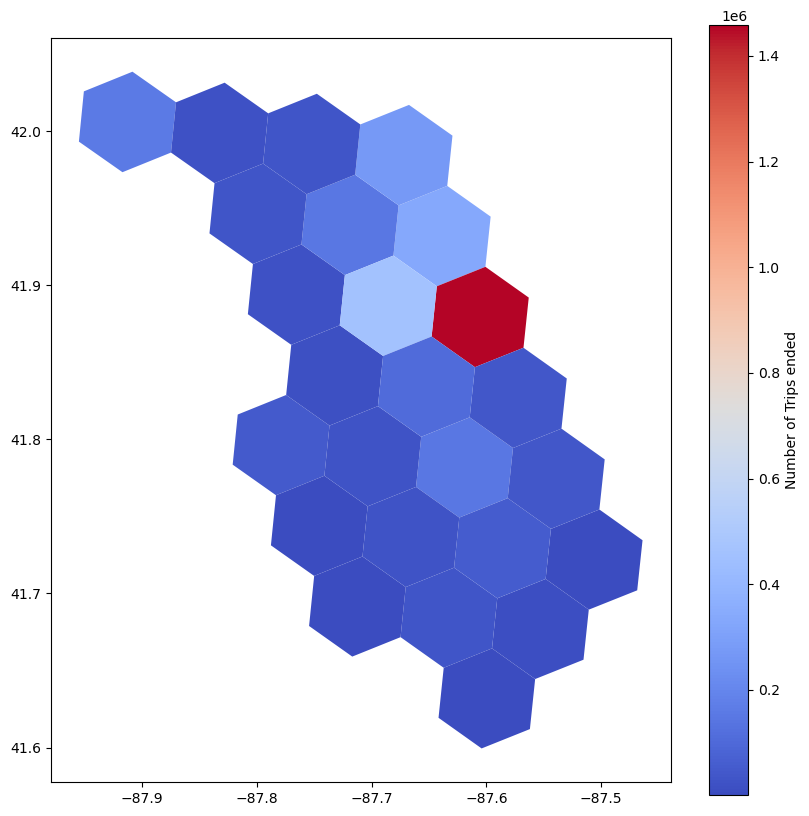

In [183]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

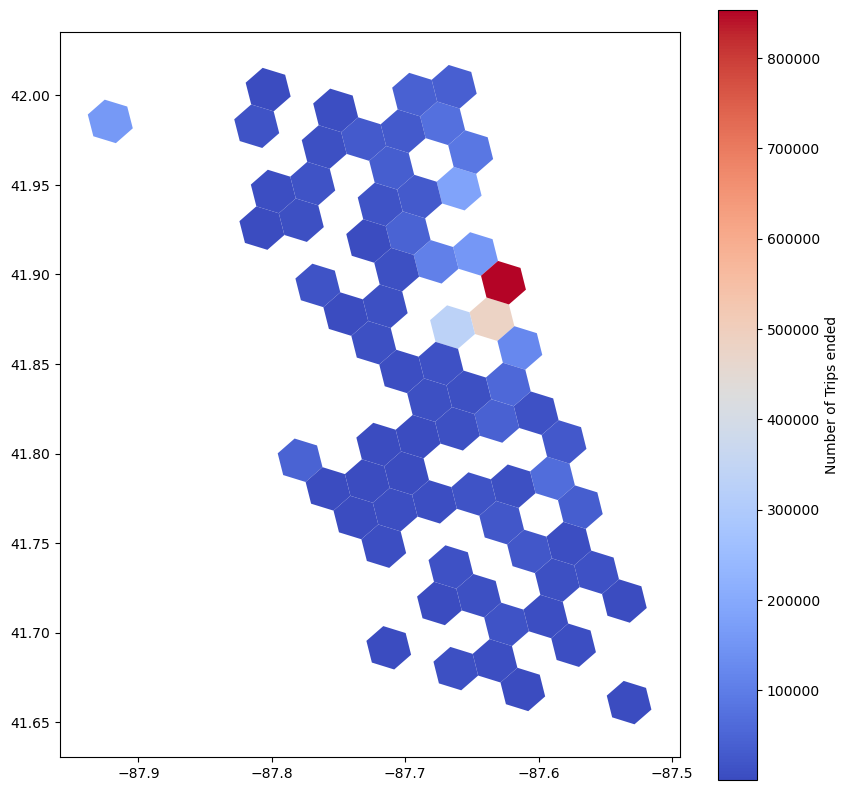

In [184]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

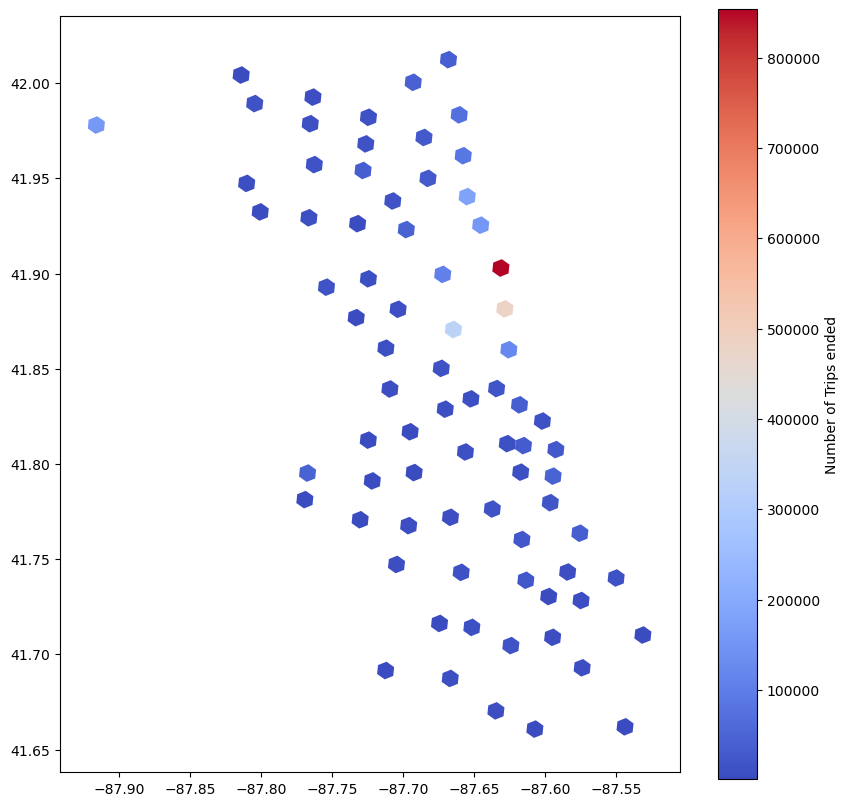

In [185]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

### Trip balance

<AxesSubplot: >

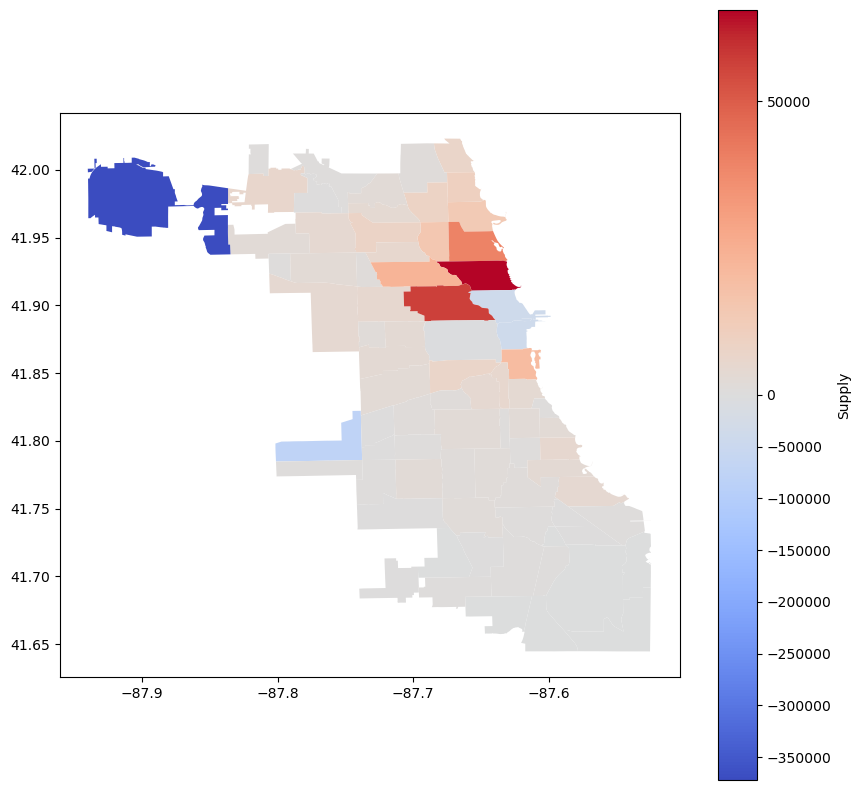

In [186]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

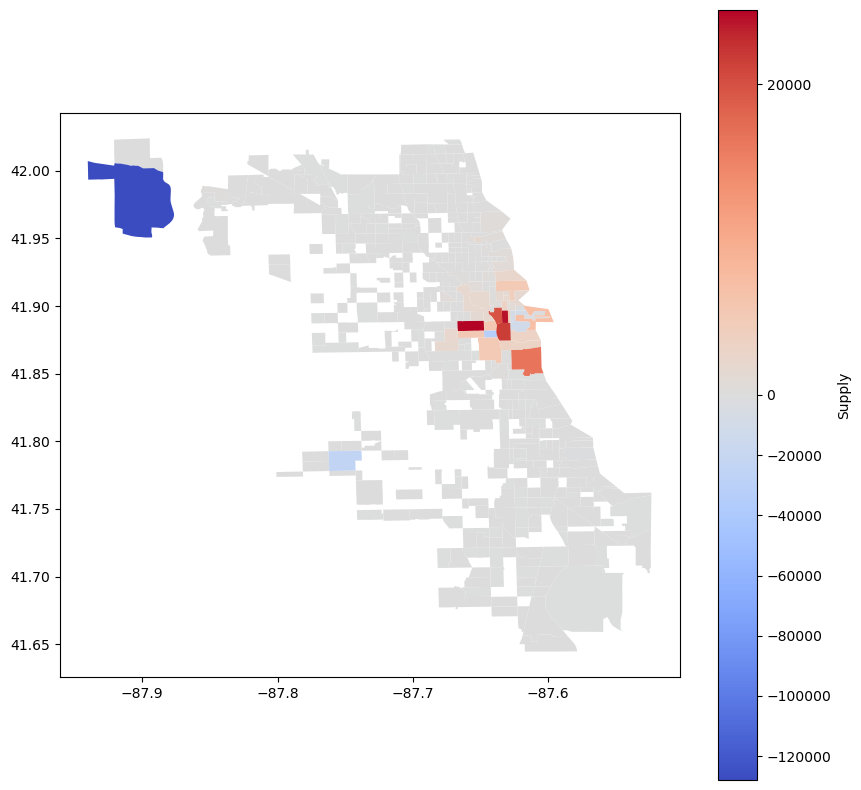

In [187]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

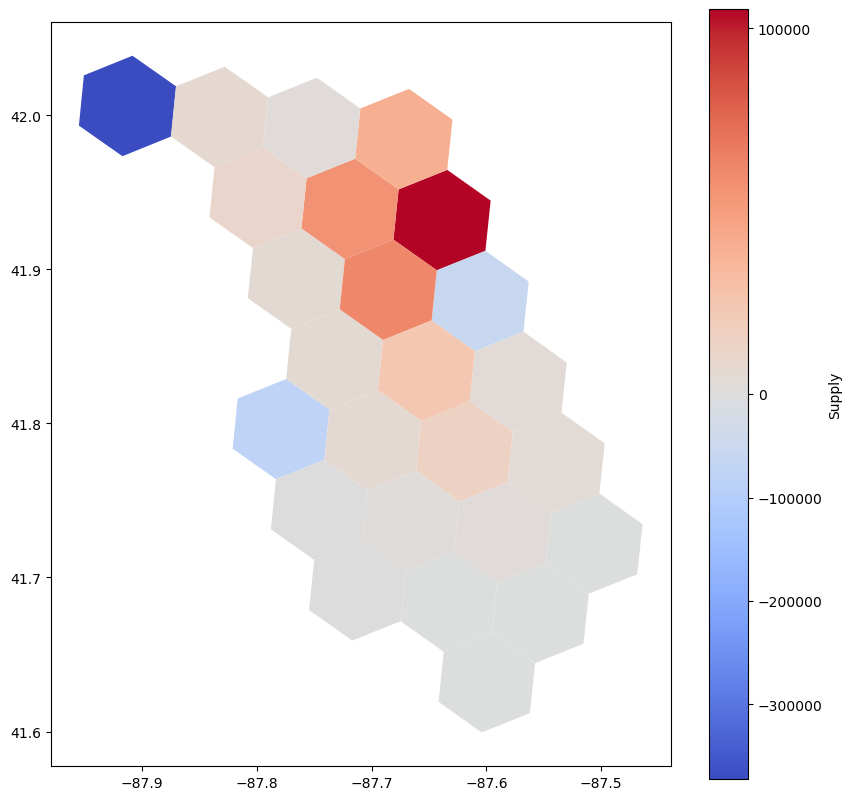

In [188]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

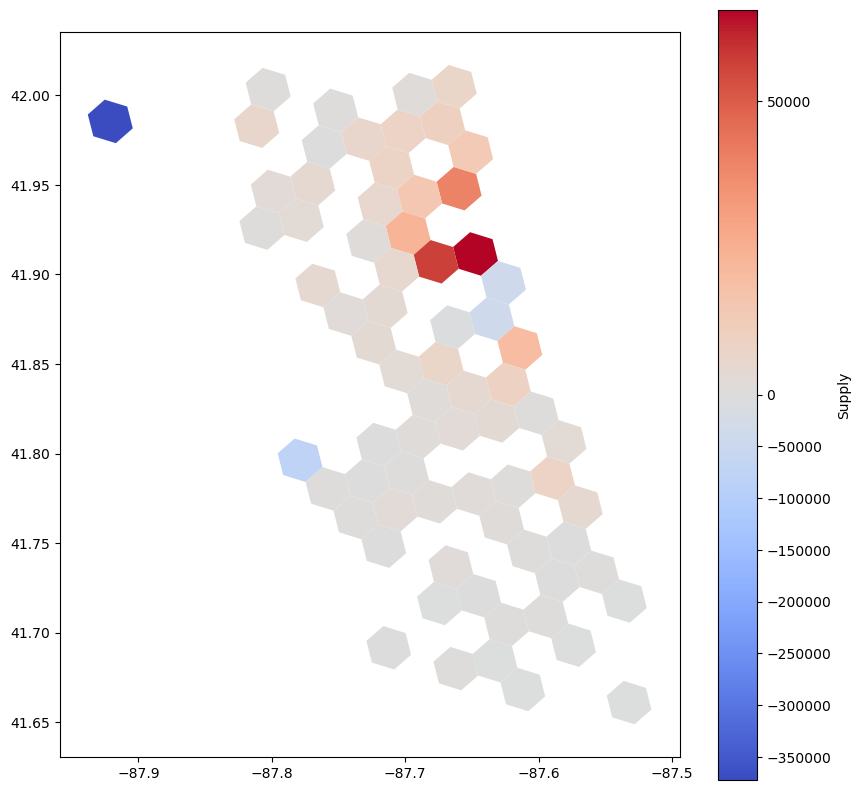

In [189]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

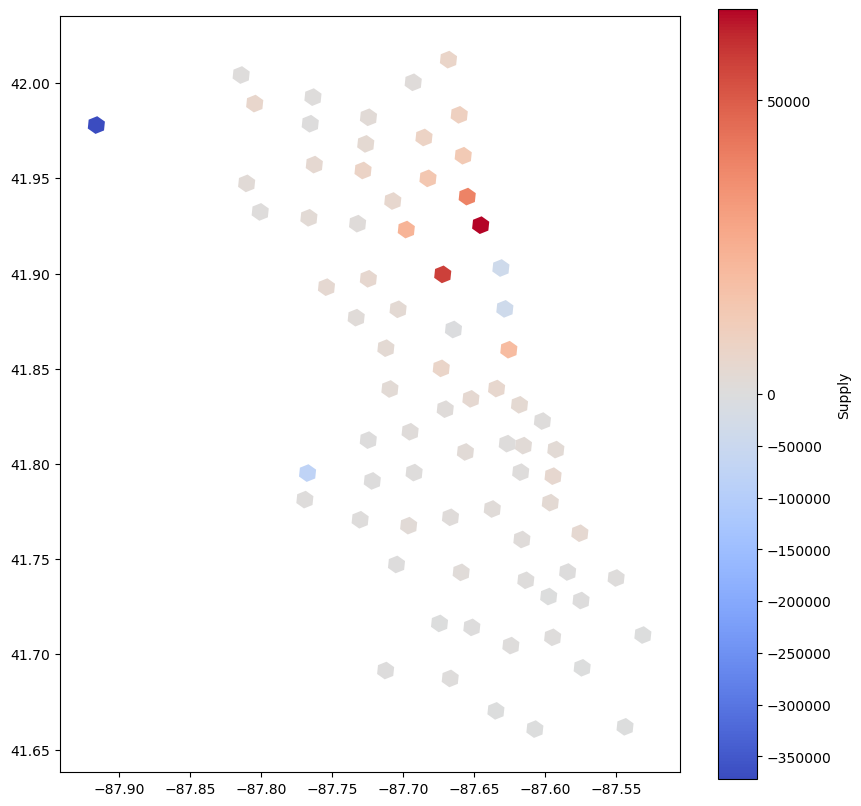

In [190]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_balance", "Supply", True)

### Top 5 Community Areas

In [191]:
cmap = ListedColormap(["blue", "orange", "green", "red", "purple"])

In [192]:
# top_community_areas
taxi_by_community_area_top_list = list(taxi_by_community_area.sort_values(by='trip_amount_pickup', key=taxi_by_community_area['trip_amount_dropoff'].add, ascending=False).groupby('community_area').head(5).head(5)["community_area"])
taxi_by_community_area_top_list

[8.0, 32.0, 76.0, 28.0, 6.0]

In [49]:
rankings = {taxi_by_community_area_top_list[0]: "First", taxi_by_community_area_top_list[1]: "Second", taxi_by_community_area_top_list[2]: "Third", taxi_by_community_area_top_list[3]: "Fourth", taxi_by_community_area_top_list[4]: "Fifth"}

taxi_by_community_area_gpd["mark"] = taxi_by_community_area_gpd["community_area"].apply(lambda x: rankings.get(x) if x in rankings else None)

<AxesSubplot: >

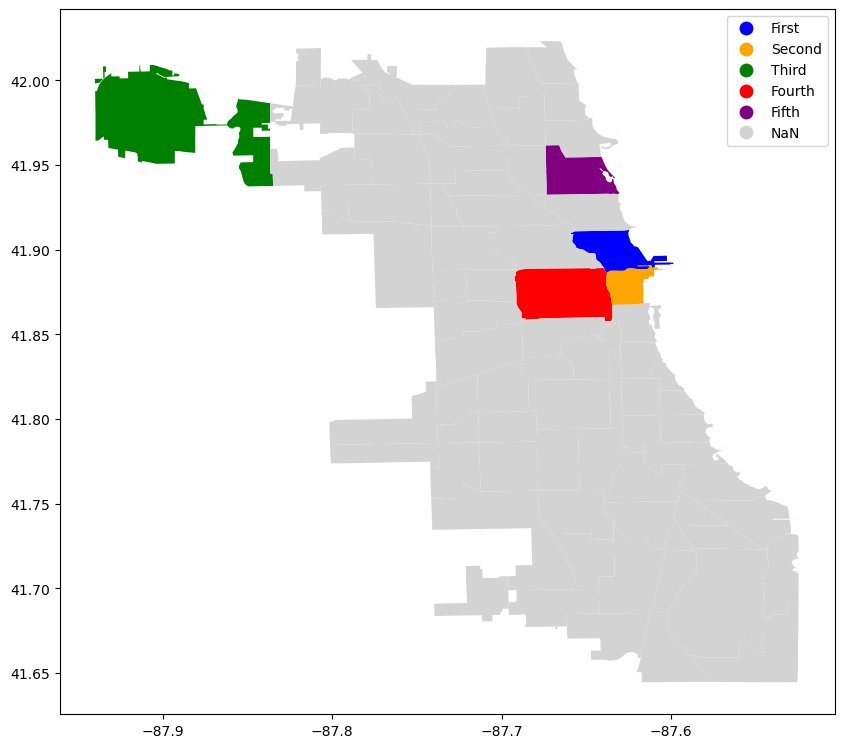

In [51]:
taxi_by_community_area_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

### Top 5 H3-6 Hexagons

In [52]:
# top_h3-6 hexagons
taxi_by_h3_6_top_list = list(taxi_by_h3_6.sort_values(by='trip_amount_pickup', key=taxi_by_h3_6['trip_amount_dropoff'].add, ascending=False).groupby('h3_6_pickup').head(5).head(5)["h3_6_pickup"])
taxi_by_h3_6_top_list

['862664c1fffffff',
 '862664cafffffff',
 '862759347ffffff',
 '862664c17ffffff',
 '862664d8fffffff']

In [53]:
rankings_h3_6 = {taxi_by_h3_6_top_list[0]: "First", taxi_by_h3_6_top_list[1]: "Second", taxi_by_h3_6_top_list[2]: "Third", taxi_by_h3_6_top_list[3]: "Fourth", taxi_by_h3_6_top_list[4]: "Fifth"}

taxi_h3_6_gpd["mark"] = taxi_h3_6_gpd.index.map(lambda x: rankings_h3_6.get(x) if x in rankings_h3_6 else None)

<AxesSubplot: >

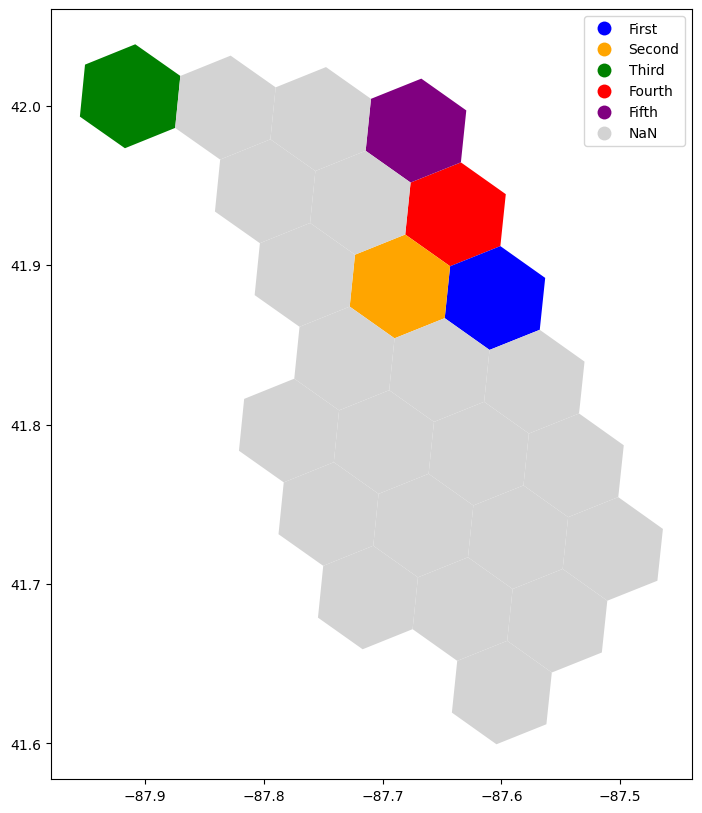

In [54]:
taxi_h3_6_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

### Top 5 H3-8 Hexagons

In [55]:
# top_h3-8 hexagons
taxi_by_h3_8_top_list = list(taxi_by_h3_8.sort_values(by='trip_amount_pickup', key=taxi_by_h3_8['trip_amount_dropoff'].add, ascending=False).groupby('h3_8_pickup').head(5).head(5)["h3_8_pickup"])
taxi_by_h3_8_top_list

['882664c1edfffff',
 '882664c1a9fffff',
 '8827593433fffff',
 '882664ca91fffff',
 '882664c163fffff']

In [56]:
rankings_h3_8 = {taxi_by_h3_8_top_list[0]: "First", taxi_by_h3_8_top_list[1]: "Second", taxi_by_h3_8_top_list[2]: "Third", taxi_by_h3_8_top_list[3]: "Fourth", taxi_by_h3_8_top_list[4]: "Fifth"}

taxi_h3_8_gpd["mark"] = taxi_h3_8_gpd.index.map(lambda x: rankings_h3_8.get(x) if x in rankings_h3_8 else None)

<AxesSubplot: >

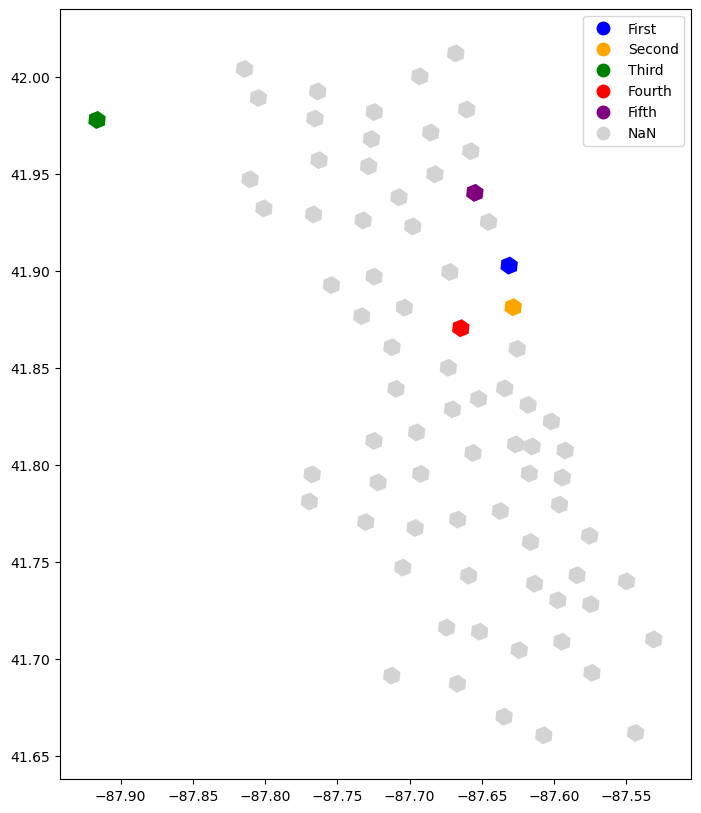

In [57]:
taxi_h3_8_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

## Spatio-Temporal Analysis

In [58]:
taxi_by_census_tract_1H = pd.read_csv(f"{file_path}taxi_by_census_tract_1H.csv")
taxi_by_community_area_1H = pd.read_csv(f"{file_path}taxi_by_community_area_1H.csv")
taxi_by_h3_6_1H = pd.read_csv(f"{file_path}taxi_by_h3_6_1H.csv")
taxi_by_h3_7_1H = pd.read_csv(f"{file_path}taxi_by_h3_7_1H.csv")
taxi_by_h3_8_1H = pd.read_csv(f"{file_path}taxi_by_h3_8_1H.csv")
taxi_by_census_tract_4H = pd.read_csv(f"{file_path}taxi_by_census_tract_4H.csv")
taxi_by_community_area_4H = pd.read_csv(f"{file_path}taxi_by_community_area_4H.csv")
taxi_by_h3_6_4H = pd.read_csv(f"{file_path}taxi_by_h3_6_4H.csv")
taxi_by_h3_7_4H = pd.read_csv(f"{file_path}taxi_by_h3_7_4H.csv")
taxi_by_h3_8_4H = pd.read_csv(f"{file_path}taxi_by_h3_8_4H.csv")
taxi_by_census_tract_24H = pd.read_csv(f"{file_path}taxi_by_census_tract_24H.csv")
taxi_by_community_area_24H = pd.read_csv(f"{file_path}taxi_by_community_area_24H.csv")
taxi_by_h3_6_24H = pd.read_csv(f"{file_path}taxi_by_h3_6_24H.csv")
taxi_by_h3_7_24H = pd.read_csv(f"{file_path}taxi_by_h3_7_24H.csv")
taxi_by_h3_8_24H = pd.read_csv(f"{file_path}taxi_by_h3_8_24H.csv")

We add all these dataframes to lists for convenience

In [59]:
dataframes_1H = [taxi_by_census_tract_1H, taxi_by_community_area_1H, taxi_by_h3_6_1H, taxi_by_h3_7_1H, taxi_by_h3_8_1H]
dataframes_4H = [taxi_by_census_tract_4H, taxi_by_community_area_4H, taxi_by_h3_6_4H, taxi_by_h3_7_4H, taxi_by_h3_8_4H]
dataframes_24H = [taxi_by_census_tract_24H, taxi_by_community_area_24H, taxi_by_h3_6_24H, taxi_by_h3_7_24H, taxi_by_h3_8_24H]

In [60]:
def add_day(dataframelist):
    for dataframe in dataframelist:
        dataframe["day"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.timetuple().tm_yday)
        dataframe["weekday"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.timetuple().tm_wday)
        dataframe["week"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: datetime.fromtimestamp(mktime(x.timetuple())).isocalendar().week)
        
def add_hour_and_absolute_hour(dataframelist):
    for dataframe in dataframelist:
        dataframe["hour"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.hour)
        dataframe["abs_hour"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.hour * x.timetuple().tm_yday)

In [61]:
add_day(dataframes_1H)
add_hour_and_absolute_hour(dataframes_1H)
add_day(dataframes_4H)
add_hour_and_absolute_hour(dataframes_4H)
add_day(dataframes_24H)
taxi_by_census_tract_4H.head(5)

trip_start_timestamp  census_tract  trip_amount_pickup  mean_trip_seconds  \
0  2021-01-01 08:00:00  1.703132e+10                 1.0             1445.0   
1  2021-01-01 08:00:00  1.703198e+10                 2.0             1883.5   
2  2021-01-01 12:00:00  1.703108e+10                 2.0              600.0   
3  2021-01-01 12:00:00  1.703108e+10                 1.0              442.0   
4  2021-01-01 12:00:00  1.703128e+10                 6.0              510.0   

   mean_trip_miles  mean_trip_total  start_temp  start_precip  \
0        17.960000           55.620    0.370000           1.0   
1         0.035000           76.375    0.140000           0.0   
2         1.950000            8.875    1.330000           1.0   
3         1.080000            9.250    0.900000           1.0   
4         1.483333            7.750    1.043333           1.0   

   start_windspeed  end_temp  end_precip  end_windspeed  trip_amount_dropoff  \
0        10.700000  0.370000         1.0      10.700000                  0.0   
1        10.740000  0.135000         0.0      10.855000                  3.0   
2        11.150000  1.330000         1.0      11.790000                  0.0   
3        11.180000  0.900000         1.0      11.180000                  0.0   
4        11.383333  1.043333         1.0      11.383333                  8.0   

   trip_amount_balance                                           geometry  \
0                 -1.0  MULTIPOLYGON (((-87.61343799999288 41.88788700...   
1                  1.0  MULTIPOLYGON (((-87.92062799997296 42.00453199...   
2                 -2.0  MULTIPOLYGON (((-87.61664600002327 41.89679299...   
3                 -1.0  MULTIPOLYGON (((-87.62960699996654 41.89003999...   
4                  2.0  MULTIPOLYGON (((-87.64592199996342 41.88178900...   

   day  weekday  week  hour  abs_hour  
0    1        4    53     8         8  
1    1        4    53     8         8  
2    1        4    53    12        12  
3    1        4    53    12        12  
4    1        4    53    12        12

### By Community Area

In [62]:
taxi_by_community_area_24H_top = taxi_by_community_area_24H[taxi_by_community_area_24H['community_area'].isin(taxi_by_community_area_top_list)]
taxi_by_community_area_1H_top = taxi_by_community_area_1H[taxi_by_community_area_1H['community_area'].isin(taxi_by_community_area_top_list)]
taxi_by_community_area_24H_top["ranking"] = taxi_by_community_area_24H_top["community_area"].apply(lambda x: rankings.get(x))
taxi_by_community_area_1H_top["ranking"] = taxi_by_community_area_1H_top["community_area"].apply(lambda x: rankings.get(x))
taxi_by_community_area_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\1257745710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_community_area_24H_top["ranking"] = taxi_by_community_area_24H_top["community_area"].apply(lambda x: rankings.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\1257745710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_community_area_1H_top["ranking"] = taxi_by_community_area_1H_top["community_area"].apply(lambda x: rankings.get(x))


trip_start_timestamp  community_area  trip_amount_pickup  \
5            2021-01-01             6.0               103.0   
7            2021-01-01             8.0               430.0   
26           2021-01-01            28.0               196.0   
30           2021-01-01            32.0               146.0   
73           2021-01-01            76.0               367.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
5          773.145631         2.929417        15.543883    0.753689   
7          875.341860         2.999349        14.228744    0.858512   
26         917.076531         4.703673        18.475918    0.743878   
30         822.294521         3.961781        17.128082    0.881849   
73        1679.673025        12.625341        46.604659    1.255341   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
5       0.368932        10.220194  0.765631    0.398058      10.215534   
7       0.451163        10.318628  0.880558    0.448837      10.302814   
26      0.545918        10.322959  0.777296    0.525510      10.331429   
30      0.554795        10.609041  0.902877    0.547945      10.609041   
73      0.422343        10.252371  1.309864    0.384196      10.237520   

    trip_amount_dropoff  trip_amount_balance  \
5                 141.0                 38.0   
7                 413.0                -17.0   
26                177.0                -19.0   
30                149.0                  3.0   
73                 81.0               -286.0   

                                             geometry  day  weekday  week  \
5   MULTIPOLYGON (((-87.64102430213292 41.95480280...    1        4    53   
7   MULTIPOLYGON (((-87.62446476694345 41.91156699...    1        4    53   
26  MULTIPOLYGON (((-87.6375883858287 41.886234136...    1        4    53   
30  MULTIPOLYGON (((-87.6094858028664 41.889399110...    1        4    53   
73  MULTIPOLYGON (((-87.83658087874365 41.98639611...    1        4    53   

   ranking  
5    Fifth  
7    First  
26  Fourth  
30  Second  
73   Third

#### Amount of trip starts

<AxesSubplot: >

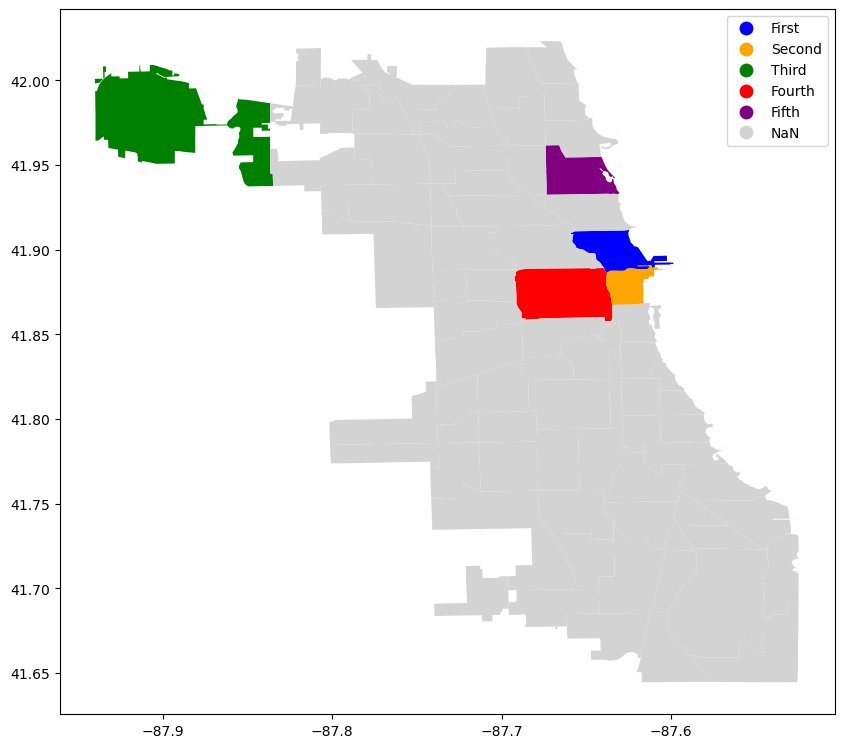

In [64]:
taxi_by_community_area_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

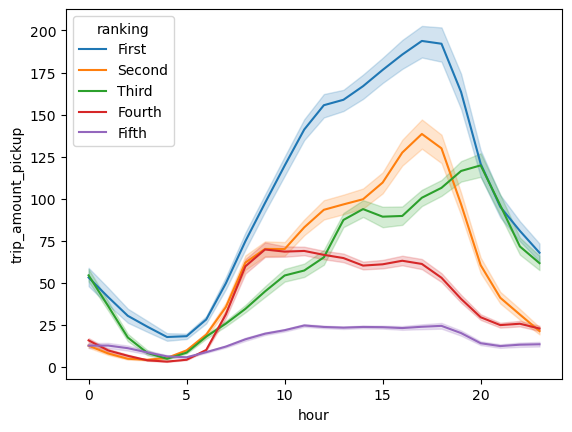

In [65]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

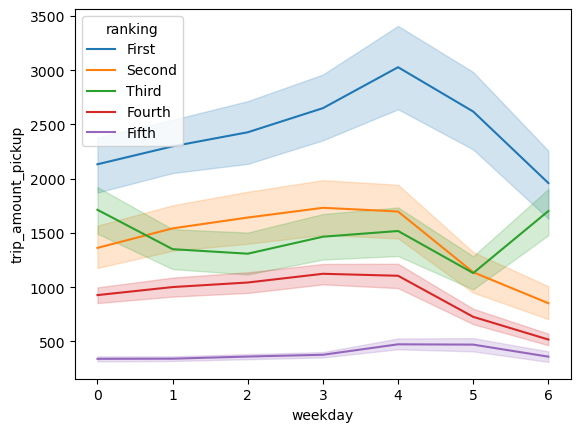

In [96]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

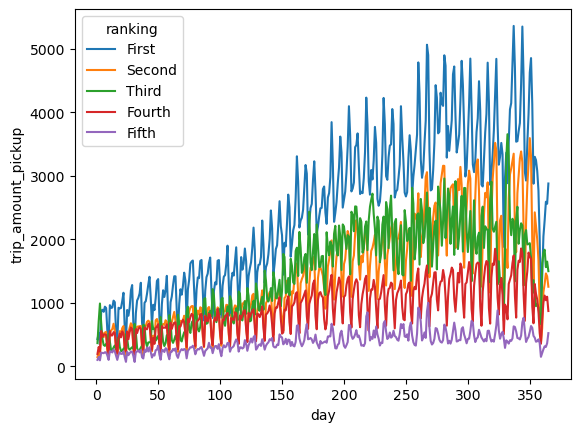

In [66]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

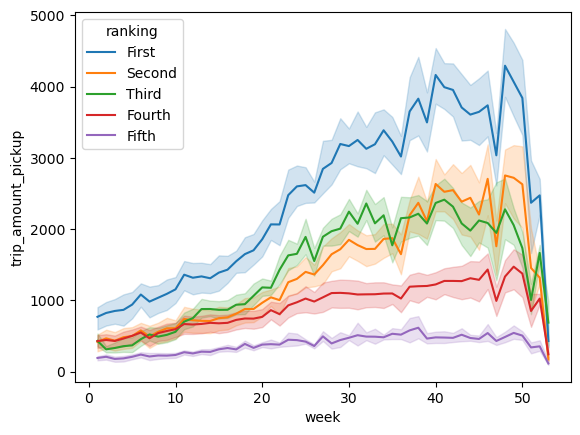

In [67]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

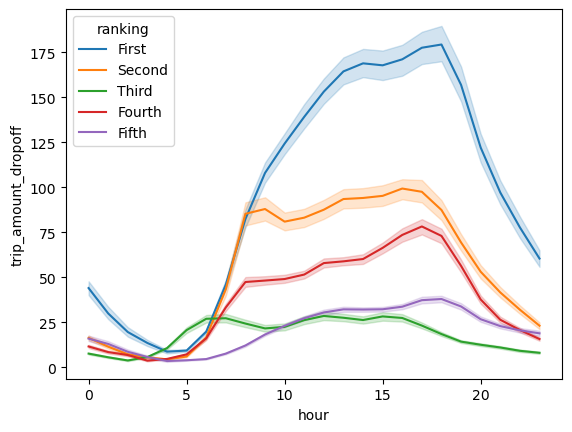

In [68]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

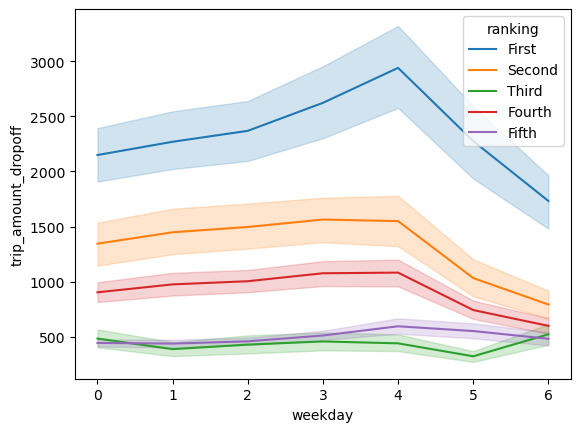

In [97]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

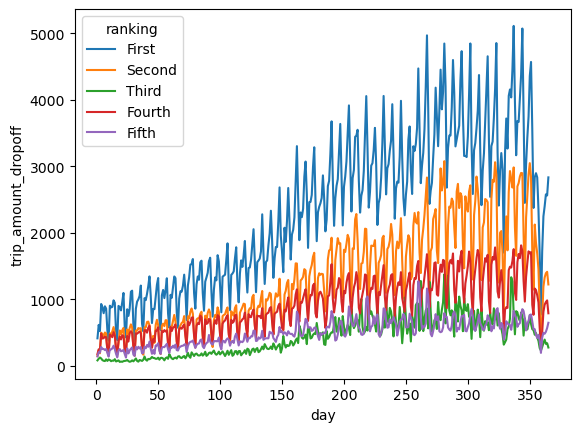

In [69]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

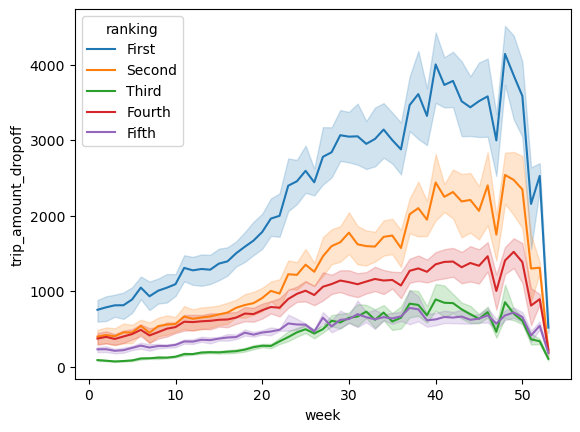

In [70]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends minus starts (balance)

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

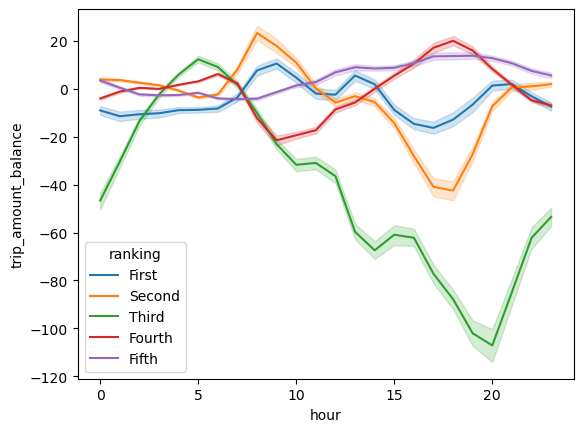

In [71]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

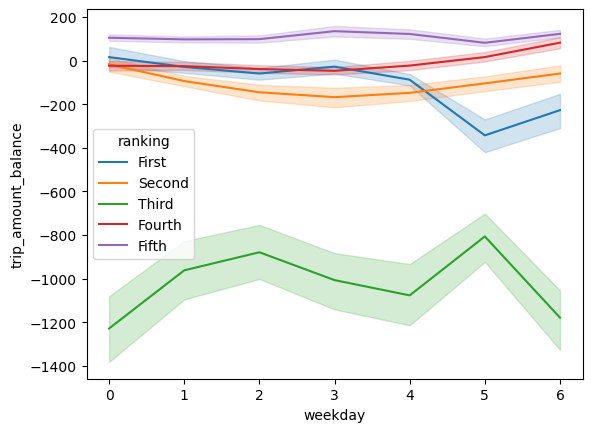

In [98]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

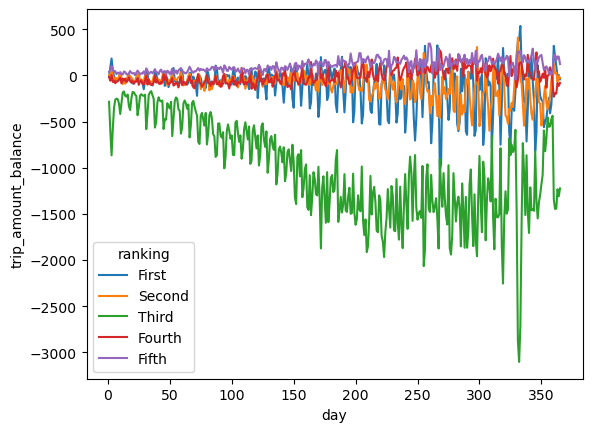

In [72]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

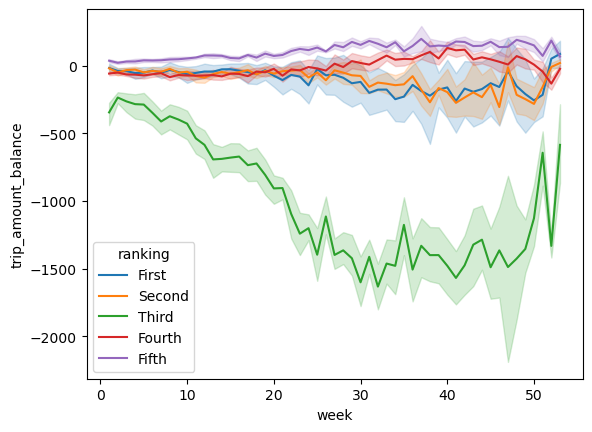

In [73]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### By H3 Resolution 6

In [74]:
taxi_by_h3_6_24H_top = taxi_by_h3_6_24H[taxi_by_h3_6_24H['h3_6_pickup'].isin(taxi_by_h3_6_top_list)]
taxi_by_h3_6_1H_top = taxi_by_h3_6_1H[taxi_by_h3_6_1H['h3_6_pickup'].isin(taxi_by_h3_6_top_list)]
taxi_by_h3_6_24H_top["ranking"] = taxi_by_h3_6_24H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
taxi_by_h3_6_1H_top["ranking"] = taxi_by_h3_6_1H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
taxi_by_h3_6_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\3823636710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_6_24H_top["ranking"] = taxi_by_h3_6_24H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\3823636710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_6_1H_top["ranking"] = taxi_by_h3_6_1H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))


trip_start_timestamp      h3_6_pickup  trip_amount_pickup  \
7            2021-01-01  862664c17ffffff               150.0   
8            2021-01-01  862664c1fffffff               638.0   
12           2021-01-01  862664cafffffff               267.0   
21           2021-01-01  862664d8fffffff               304.0   
23           2021-01-01  862759347ffffff               367.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
7         1326.566667         3.715867        16.829733    0.743667   
8          886.515674         3.504138        15.472539    0.845455   
12         976.573034         4.612959        18.413558    0.649476   
21        1255.539474         3.705329        14.970493    0.656020   
23        1679.673025        12.625341        46.604659    1.255341   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
7       0.373333        10.176533  0.776000    0.400000      10.129533   
8       0.485893        10.383950  0.872665    0.478056      10.378527   
12      0.483146        10.158052  0.687266    0.479401      10.183708   
21      0.407895        10.239704  0.692204    0.421053      10.211842   
23      0.422343        10.252371  1.309864    0.384196      10.237520   

    trip_amount_dropoff  trip_amount_balance  day  weekday  week ranking  
7                 220.0                 70.0    1        4    53  Fourth  
8                 634.0                 -4.0    1        4    53   First  
12                282.0                 15.0    1        4    53  Second  
21                338.0                 34.0    1        4    53   Fifth  
23                 81.0               -286.0    1        4    53   Third

<AxesSubplot: >

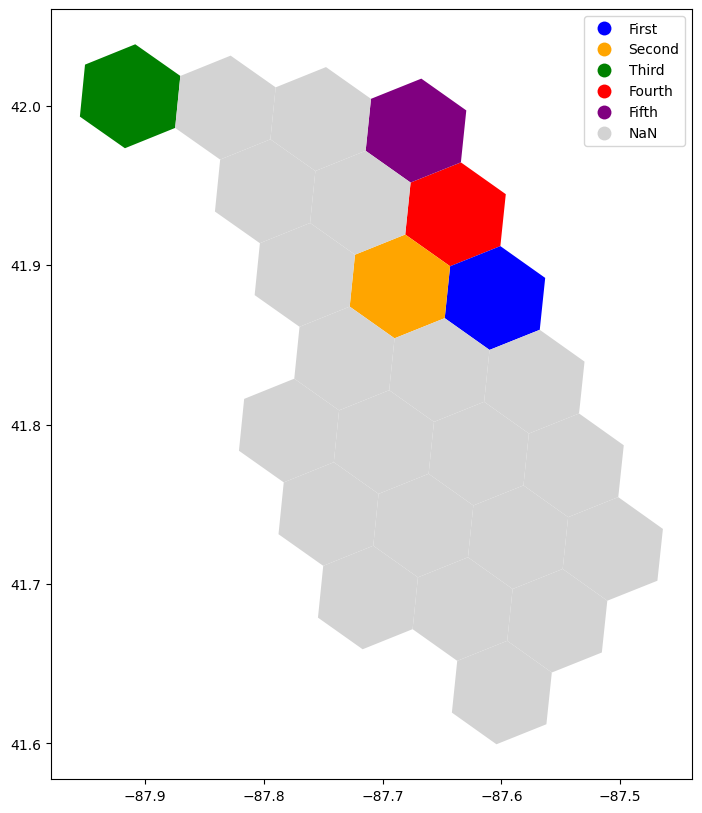

In [75]:
taxi_h3_6_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

#### Amount of trip starts

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

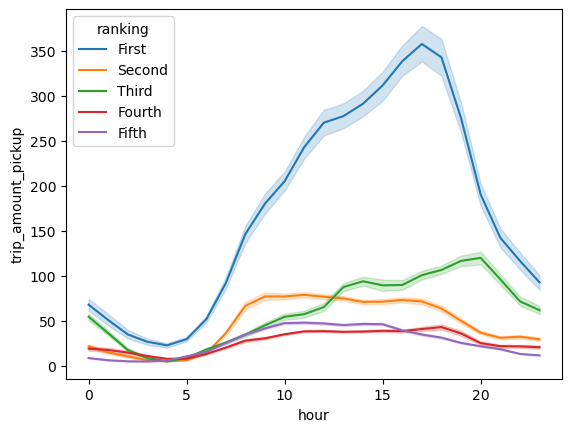

In [76]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

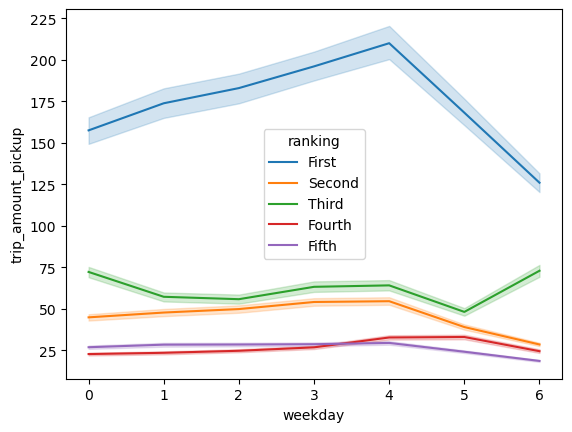

In [99]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

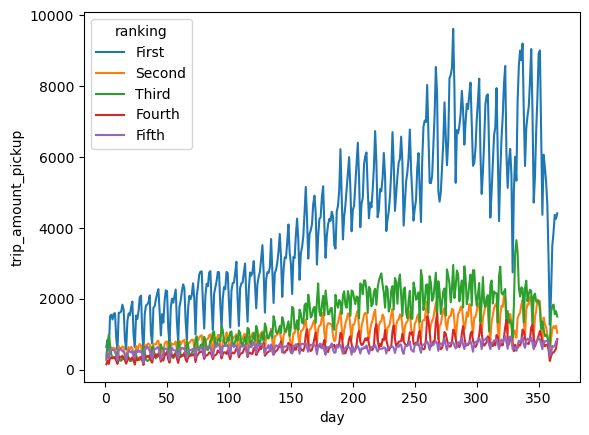

In [77]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

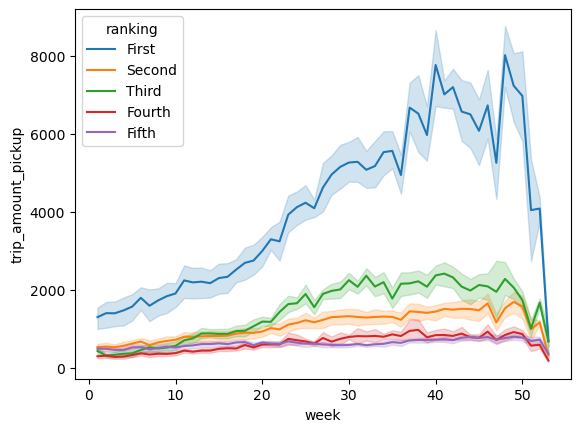

In [78]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

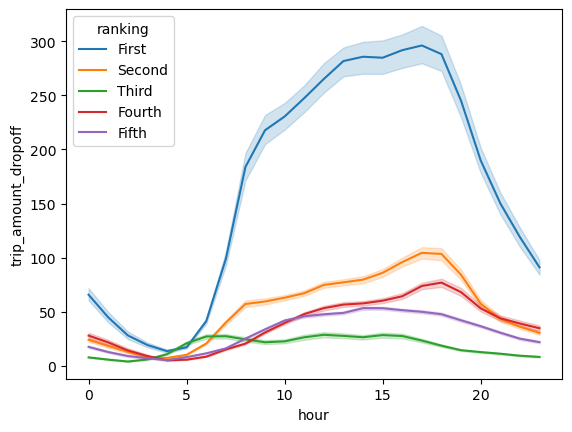

In [79]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

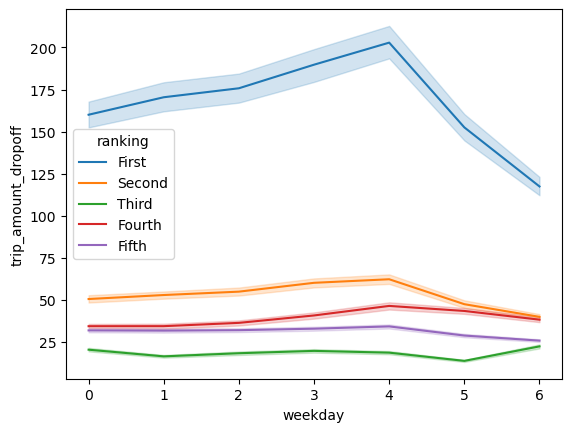

In [100]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

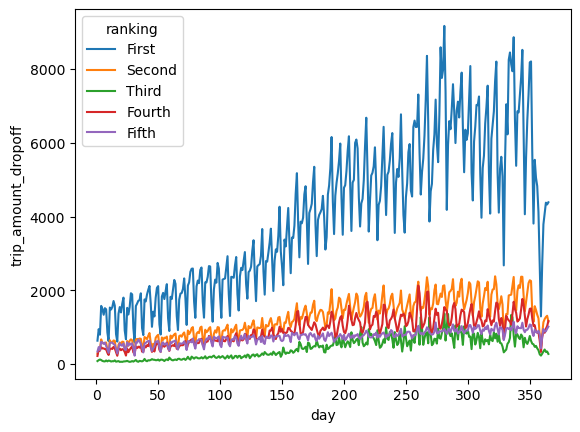

In [80]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

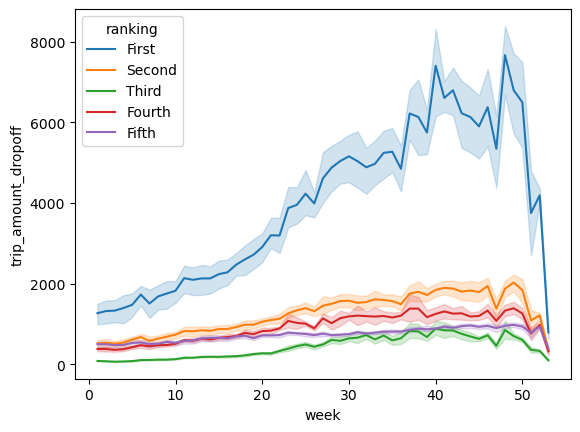

In [81]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends minus starts (balance)

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

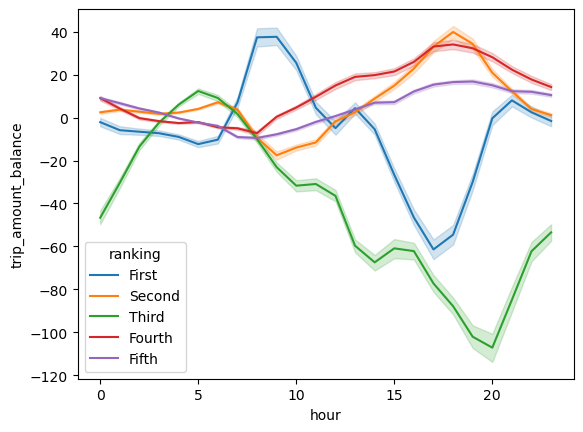

In [82]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

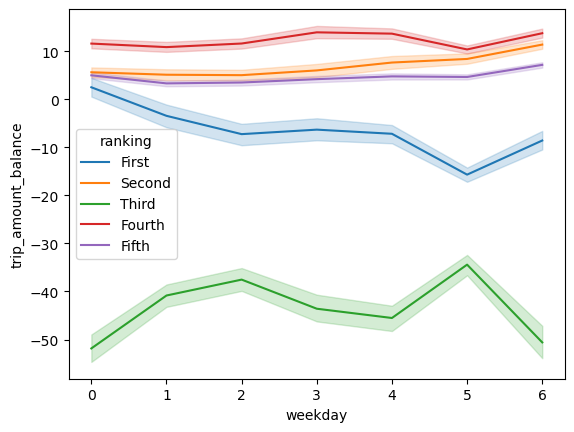

In [101]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

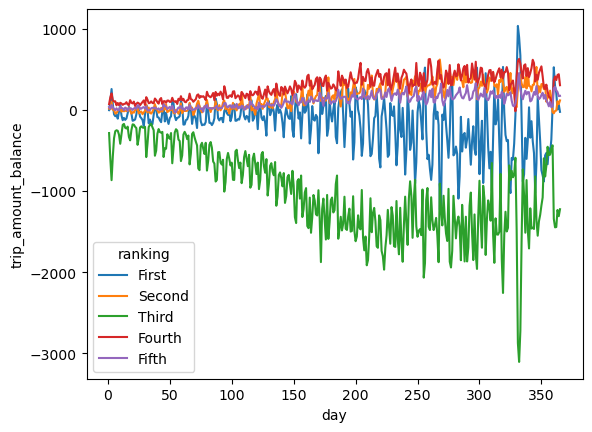

In [83]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

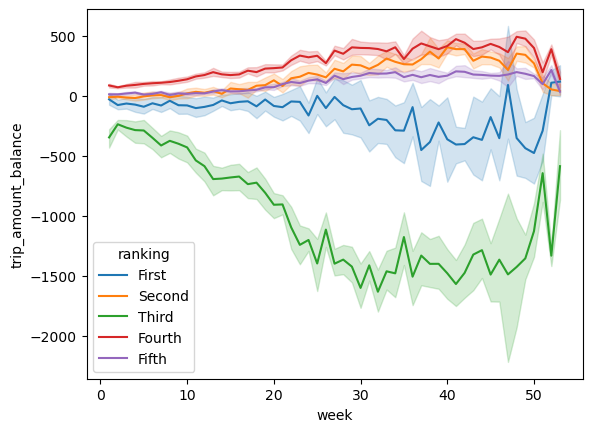

In [84]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### By H3 Resolution 8

In [85]:
taxi_by_h3_8_24H_top = taxi_by_h3_8_24H[taxi_by_h3_8_24H['h3_8_pickup'].isin(taxi_by_h3_8_top_list)]
taxi_by_h3_8_1H_top = taxi_by_h3_8_1H[taxi_by_h3_8_1H['h3_8_pickup'].isin(taxi_by_h3_8_top_list)]
taxi_by_h3_8_24H_top["ranking"] = taxi_by_h3_8_24H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
taxi_by_h3_8_1H_top["ranking"] = taxi_by_h3_8_1H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
taxi_by_h3_8_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\4155734092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_8_24H_top["ranking"] = taxi_by_h3_8_24H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_9256\4155734092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_8_1H_top["ranking"] = taxi_by_h3_8_1H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))


trip_start_timestamp      h3_8_pickup  trip_amount_pickup  \
12           2021-01-01  882664c163fffff               103.0   
13           2021-01-01  882664c1a9fffff               146.0   
15           2021-01-01  882664c1edfffff               430.0   
26           2021-01-01  882664ca91fffff               196.0   
73           2021-01-01  8827593433fffff               367.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
12         773.145631         2.929417        15.543883    0.753689   
13         822.294521         3.961781        17.128082    0.881849   
15         875.341860         2.999349        14.228744    0.858512   
26         917.076531         4.703673        18.475918    0.743878   
73        1679.673025        12.625341        46.604659    1.255341   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
12      0.368932        10.220194  0.765631    0.398058      10.215534   
13      0.554795        10.609041  0.902877    0.547945      10.609041   
15      0.451163        10.318628  0.880558    0.448837      10.302814   
26      0.545918        10.322959  0.777296    0.525510      10.331429   
73      0.422343        10.252371  1.309864    0.384196      10.237520   

    trip_amount_dropoff  trip_amount_balance  day  weekday  week ranking  
12                141.0                 38.0    1        4    53   Fifth  
13                149.0                  3.0    1        4    53  Second  
15                413.0                -17.0    1        4    53   First  
26                177.0                -19.0    1        4    53  Fourth  
73                 81.0               -286.0    1        4    53   Third

<AxesSubplot: >

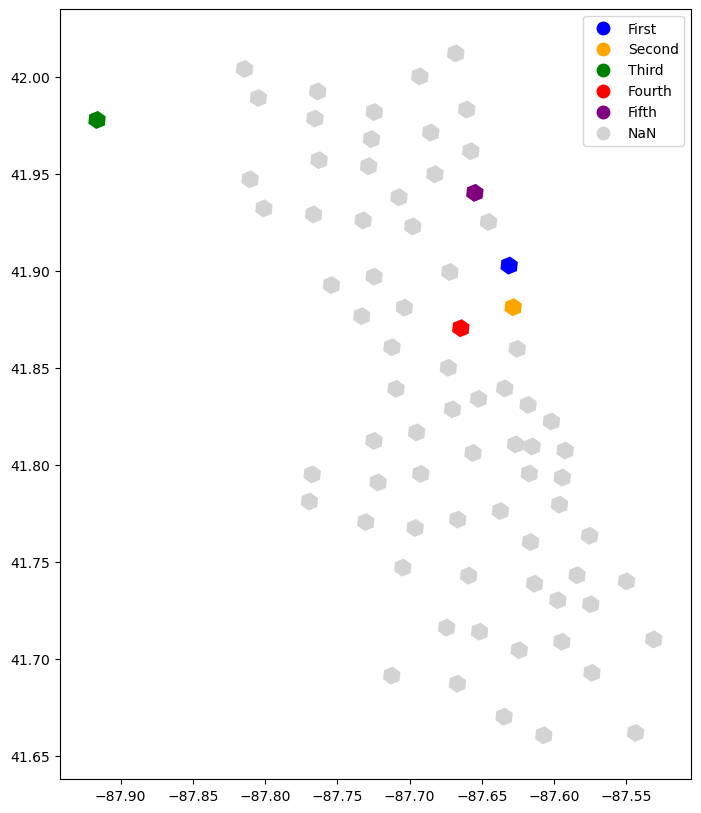

In [86]:
taxi_h3_8_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

#### Amount of trip starts

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

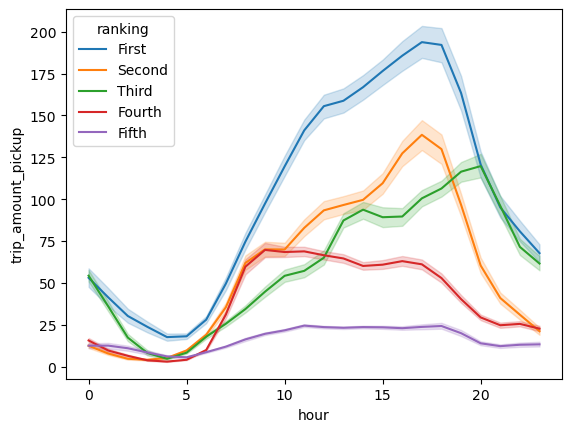

In [87]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

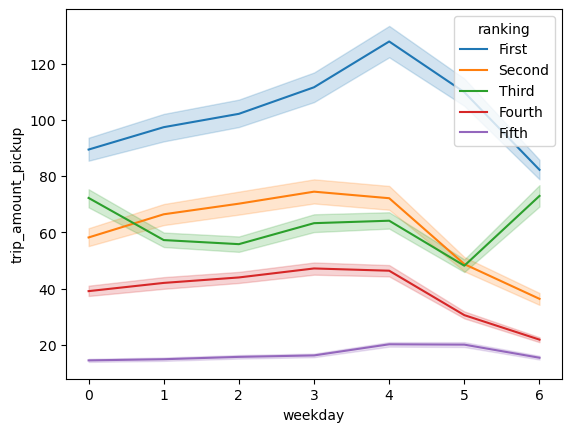

In [102]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

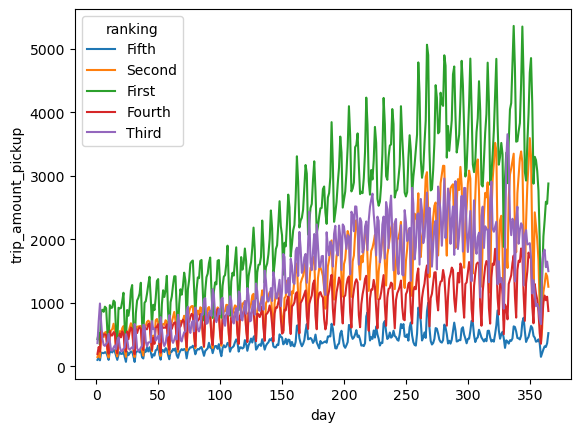

In [88]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_pickup", hue="ranking")

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

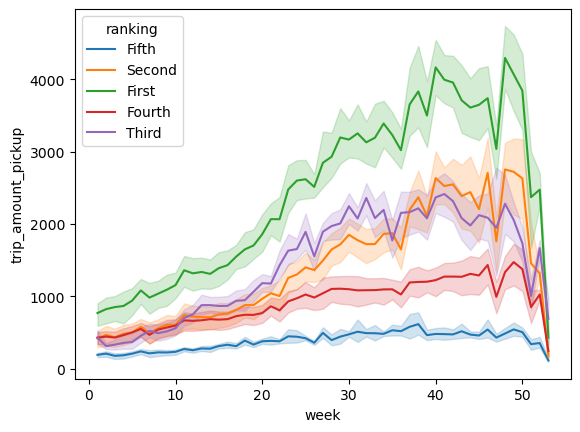

In [89]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_pickup", hue="ranking")

#### Amount of trip ends

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

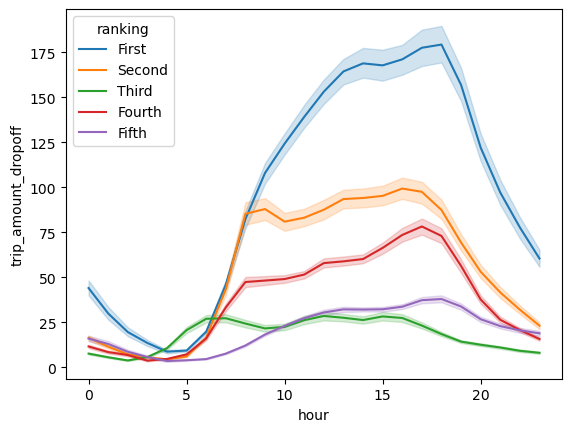

In [90]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

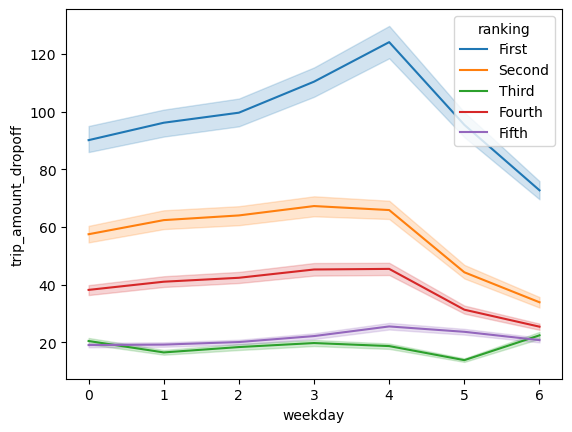

In [103]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

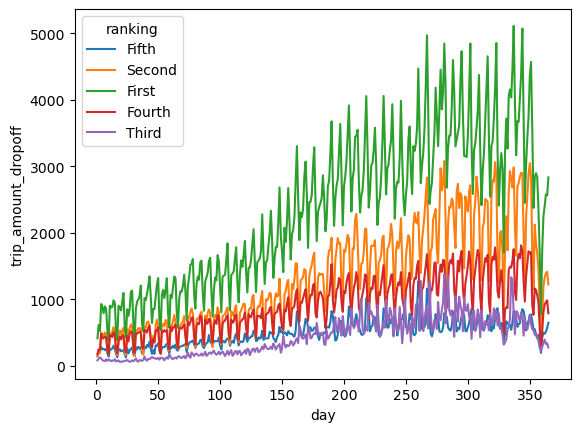

In [91]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_dropoff", hue="ranking")

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

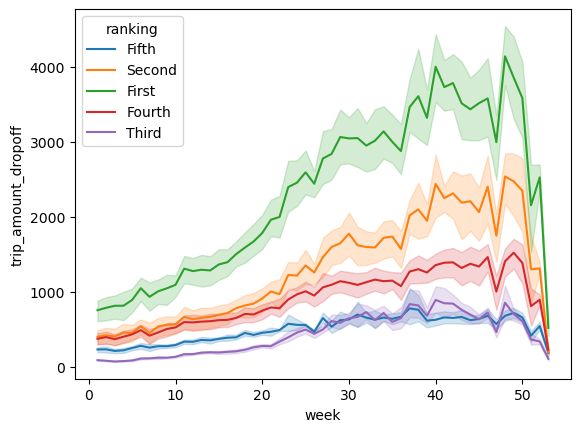

In [92]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_dropoff", hue="ranking")

#### Amount of trip ends minus starts (balance)

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

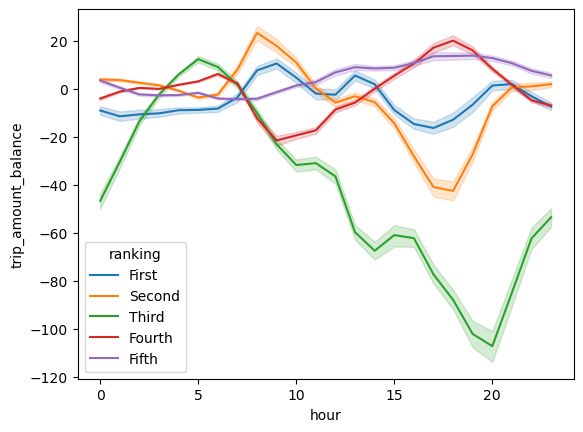

In [93]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

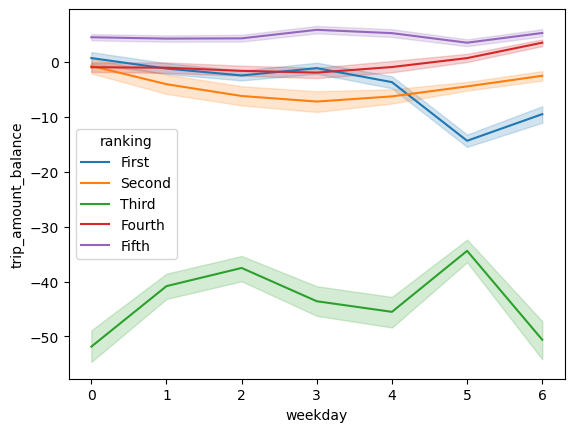

In [104]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

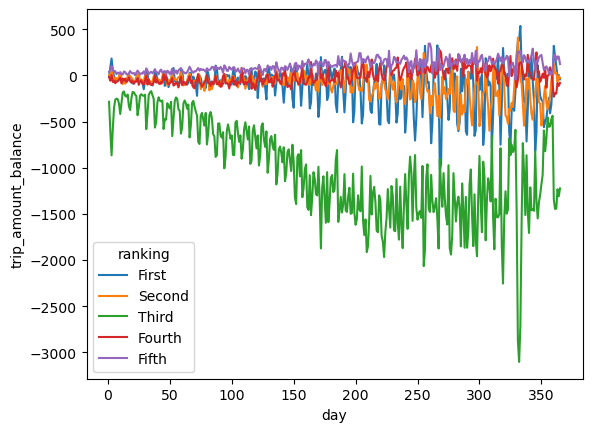

In [105]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

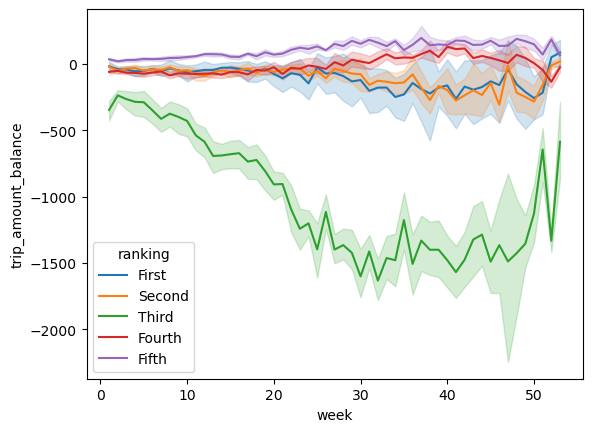

In [106]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### Geographical trends at different times of day

In [107]:
taxi_by_community_area_4H

trip_start_timestamp  community_area  trip_amount_pickup  \
0       2021-01-01 00:00:00             1.0                 7.0   
1       2021-01-01 00:00:00             2.0                 8.0   
2       2021-01-01 00:00:00             3.0                 5.0   
3       2021-01-01 00:00:00             4.0                 4.0   
4       2021-01-01 00:00:00             5.0                 2.0   
...                     ...             ...                 ...   
135712  2021-12-31 20:00:00            72.0                 3.0   
135713  2021-12-31 20:00:00            73.0                 3.0   
135714  2021-12-31 20:00:00            75.0                 2.0   
135715  2021-12-31 20:00:00            76.0               364.0   
135716  2021-12-31 20:00:00            77.0                34.0   

        mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
0              561.142857         2.564286        11.000000   -1.282857   
1             1257.750000         3.165000        14.218750   -1.287500   
2              516.000000         2.078000        12.700000   -1.280000   
3              419.750000         2.225000         8.562500   -1.227500   
4               26.000000         0.110000         3.500000   -1.160000   
...                   ...              ...              ...         ...   
135712         778.666667         3.830000        20.833333    4.833333   
135713         833.000000         7.906667        21.833333    4.813333   
135714        1260.000000         6.800000        32.500000    4.245000   
135715        1413.384615        11.689780        49.445082    4.692967   
135716         698.588235         2.857353        15.705294    4.545000   

        start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
0                0.0         7.190000 -1.275714         0.0       7.300000   
1                0.0         6.898750 -1.278750         0.0       7.136250   
2                0.0         7.120000 -1.286000         0.0       7.192000   
3                0.0         7.300000 -1.227500         0.0       7.300000   
4                0.0         7.300000 -1.160000         0.0       7.300000   
...              ...              ...       ...         ...            ...   
135712           0.0         8.926667  4.833333         0.0       8.926667   
135713           0.0         8.500000  4.813333         0.0       8.500000   
135714           0.0        10.265000  4.245000         0.0      10.265000   
135715           0.0         9.013709  4.546209         0.0       9.530027   
135716           0.0         9.396176  4.467353         0.0       9.599118   

        trip_amount_dropoff  trip_amount_balance  \
0                       7.0                  0.0   
1                       6.0                 -2.0   
2                      10.0                  5.0   
3                       8.0                  4.0   
4                       2.0                  0.0   
...                     ...                  ...   
135712                  2.0                 -1.0   
135713                  4.0                  1.0   
135714                  3.0                  1.0   
135715                 32.0               -332.0   
135716                 56.0                 22.0   

                                                 geometry  day  weekday  week  \
0       MULTIPOLYGON (((-87.65455590025104 41.99816614...    1        4    53   
1       MULTIPOLYGON (((-87.6846530946559 42.019484772...    1        4    53   
2       MULTIPOLYGON (((-87.64102430213292 41.95480280...    1        4    53   
3       MULTIPOLYGON (((-87.6744075678037 41.976103404...    1        4    53   
4       MULTIPOLYGON (((-87.67336415409336 41.93234274...    1        4    53   
...                                                   ...  ...      ...   ...   
135712  MULTIPOLYGON (((-87.67308255594219 41.73565672...  365        4    52   
135713  MULTIPOLYGON (((-87.63373383514987 41.72885272...  365        4    52   
135714  MU

In [116]:
taxi_by_h3_7_4H_gpd = taxi_by_h3_7_4H.set_index("h3_7_pickup").h3.h3_to_geo_boundary()
taxi_by_h3_7_4H_gpd

trip_start_timestamp  trip_amount_pickup  mean_trip_seconds  \
h3_7_pickup                                                                   
872664520ffffff  2021-01-01 00:00:00                 6.0       10341.166667   
87266452dffffff  2021-01-01 00:00:00                 2.0        2107.500000   
872664562ffffff  2021-01-01 00:00:00                 1.0         781.000000   
872664564ffffff  2021-01-01 00:00:00                 1.0        1898.000000   
872664c13ffffff  2021-01-01 00:00:00                 7.0         693.571429   
...                              ...                 ...                ...   
872664d98ffffff  2021-12-31 20:00:00                 4.0        1423.000000   
872664d99ffffff  2021-12-31 20:00:00                12.0         933.250000   
872664d9bffffff  2021-12-31 20:00:00                 9.0         639.333333   
872759343ffffff  2021-12-31 20:00:00               364.0        1413.384615   
872759369ffffff  2021-12-31 20:00:00                 7.0        1002.857143   

                 mean_trip_miles  mean_trip_total  start_temp  start_precip  \
h3_7_pickup                                                                   
872664520ffffff         9.050000        39.680000   -1.321667           0.0   
87266452dffffff         8.375000        27.875000   -1.305000           0.0   
872664562ffffff         5.010000        15.000000   -1.330000           0.0   
872664564ffffff         9.600000        30.000000   -1.160000           0.0   
872664c13ffffff         3.421429        14.670000   -1.275714           0.0   
...                          ...              ...         ...           ...   
872664d98ffffff         9.040000        26.000000    4.552500           0.0   
872664d99ffffff         7.923333        26.825000    4.705833           0.0   
872664d9bffffff         4.606667        14.888889    4.717778           0.0   
872759343ffffff        11.689780        49.445082    4.692967           0.0   
872759369ffffff         9.801429        30.680000    4.484286           0.0   

                 start_windspeed  end_temp  end_precip  end_windspeed  \
h3_7_pickup                                                             
872664520ffffff         6.478333 -0.861667    0.166667       7.641667   
87266452dffffff         6.735000 -1.305000    0.000000       6.735000   
872664562ffffff         6.350000 -1.330000    0.000000       6.350000   
872664564ffffff         7.300000 -0.980000    0.000000       7.330000   
872664c13ffffff         6.944286 -1.250000    0.000000       6.948571   
...                          ...       ...         ...            ...   
872664d98ffffff         9.640000  4.430000    0.000000       9.900000   
872664d99ffffff         9.080000  4.595833    0.000000       9.367500   
872664d9bffffff         9.015556  4.618889    0.000000       9.141111   
872759343ffffff         9.013709  4.546209    0.000000       9.530027   
872759369ffffff         9.827143  4.422857    0.000000      10.158571   

                 trip_amount_dropoff  trip_amount_balance  day  weekday  week  \
h3_7_pickup                                                                     
872664520ffffff                  1.0                 -5.0    1        4    53   
87266452dffffff                  1.0                 -1.0    1        4    53   
872664562ffffff                  1.0                  0.0    1        4    53   
872664564ffffff                  0.0                 -1.0    1        4    53   
872664c13ffffff                  9.0                  2.0    1        4    53   
...                              ...                  ...  ...      ...   ...   
872664d98ffffff                  4.0                  0.0  365        4    52   
872664d99ffffff                 13.0                  1.0  365        4    52   
872664d9bffffff                  7.0                 -2.0  365        4    52   
872759343ffffff                 32.0               -332.0  365        4    52   
872759369ffffff                  9.0  

In [117]:
taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 4]

trip_start_timestamp  trip_amount_pickup  mean_trip_seconds  \
h3_7_pickup                                                                   
872664191ffffff  2021-01-01 04:00:00                 1.0        1095.000000   
872664196ffffff  2021-01-01 04:00:00                 1.0        1020.000000   
872664560ffffff  2021-01-01 04:00:00                 2.0        1407.000000   
872664561ffffff  2021-01-01 04:00:00                 1.0        1080.000000   
872664562ffffff  2021-01-01 04:00:00                 1.0        5292.000000   
...                              ...                 ...                ...   
872664d98ffffff  2021-12-31 04:00:00                 1.0         777.000000   
872664d99ffffff  2021-12-31 04:00:00                12.0        1219.750000   
872664d9bffffff  2021-12-31 04:00:00                 7.0         594.428571   
872759343ffffff  2021-12-31 04:00:00                47.0        1376.446809   
872759369ffffff  2021-12-31 04:00:00                 3.0        1015.000000   

                 mean_trip_miles  mean_trip_total  start_temp  start_precip  \
h3_7_pickup                                                                   
872664191ffffff        12.650000        32.500000   -0.310000           0.0   
872664196ffffff        12.500000        31.750000   -0.770000           0.0   
872664560ffffff        12.875000        33.250000   -0.070000           0.0   
872664561ffffff        16.100000        39.250000   -0.310000           0.0   
872664562ffffff        10.270000        27.250000   -0.310000           0.0   
...                          ...              ...         ...           ...   
872664d98ffffff        13.360000        33.250000    0.230000           0.0   
872664d99ffffff         4.750000        20.250000    0.222500           0.0   
872664d9bffffff         3.948571        13.357143    0.224286           0.0   
872759343ffffff        11.728298        43.950851    0.231915           0.0   
872759369ffffff        10.870000        32.250000    0.230000           0.0   

                 start_windspeed  end_temp  end_precip  end_windspeed  \
h3_7_pickup                                                             
872664191ffffff         9.860000 -0.070000         0.0      10.210000   
872664196ffffff         8.150000 -0.770000         0.0       8.150000   
872664560ffffff        10.210000 -0.070000         0.0      10.210000   
872664561ffffff         9.860000 -0.070000         0.0      10.210000   
872664562ffffff         9.860000  0.140000         0.0      10.740000   
...                          ...       ...         ...            ...   
872664d98ffffff         1.210000  1.080000         0.0       2.770000   
872664d99ffffff         2.430000  0.295000         0.0       2.435833   
872664d9bffffff         2.675714  0.345714         0.0       2.898571   
872759343ffffff         1.892979  0.322340         0.0       1.777021   
872759369ffffff         1.816667  0.516667         0.0       1.870000   

                 trip_amount_dropoff  trip_amount_balance  day  weekday  week  \
h3_7_pickup                                                                     
872664191ffffff                  0.0                 -1.0    1        4    53   
872664196ffffff                  0.0                 -1.0    1        4    53   
872664560ffffff                  1.0                 -1.0    1        4    53   
872664561ffffff                  1.0                  0.0    1        4    53   
872664562ffffff                  0.0                 -1.0    1        4    53   
...                              ...                  ...  ...      ...   ...   
872664d98ffffff                  1.0                  0.0  365        4    52   
872664d99ffffff                 10.0                 -2.0  365        4    52   
872664d9bffffff                  5.0                 -2.0  365        4    52   
872759343ffffff                 46.0                 -1.0  365        4    52   
872759369ffffff                  6.0  

<AxesSubplot: >

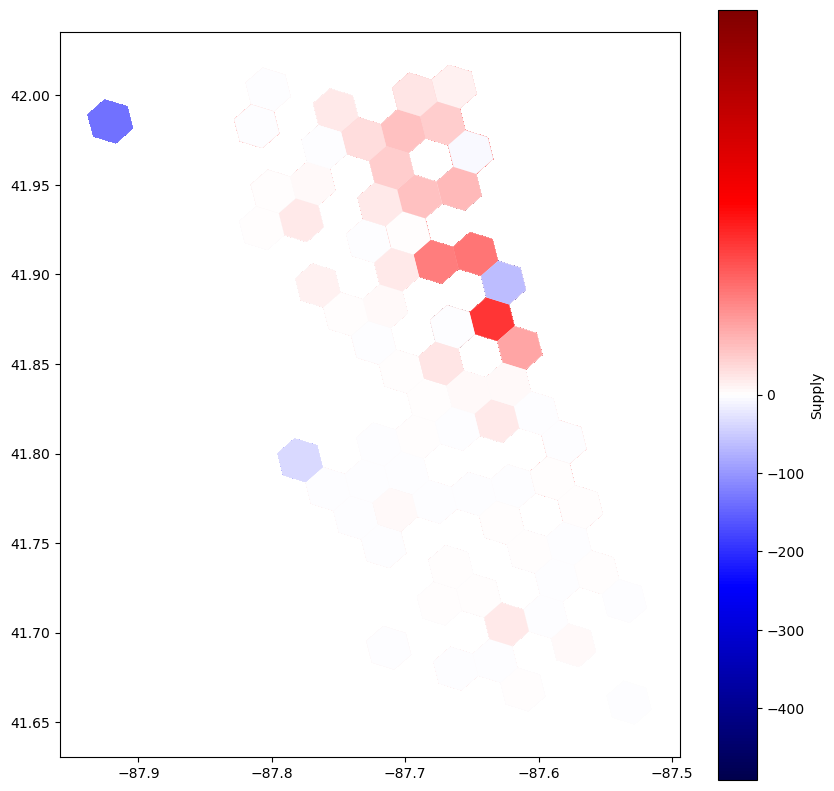

In [153]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 0], "trip_amount_balance", "Supply", True, color_scheme="seismic")

<AxesSubplot: >

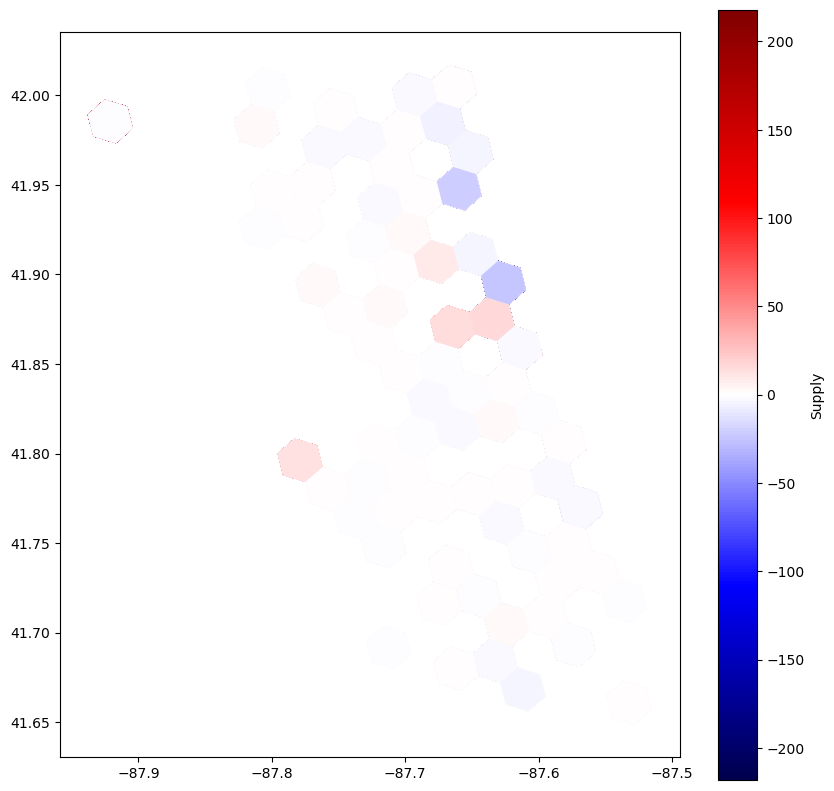

In [154]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 4], "trip_amount_balance", "Supply", True, color_scheme="seismic")

<AxesSubplot: >

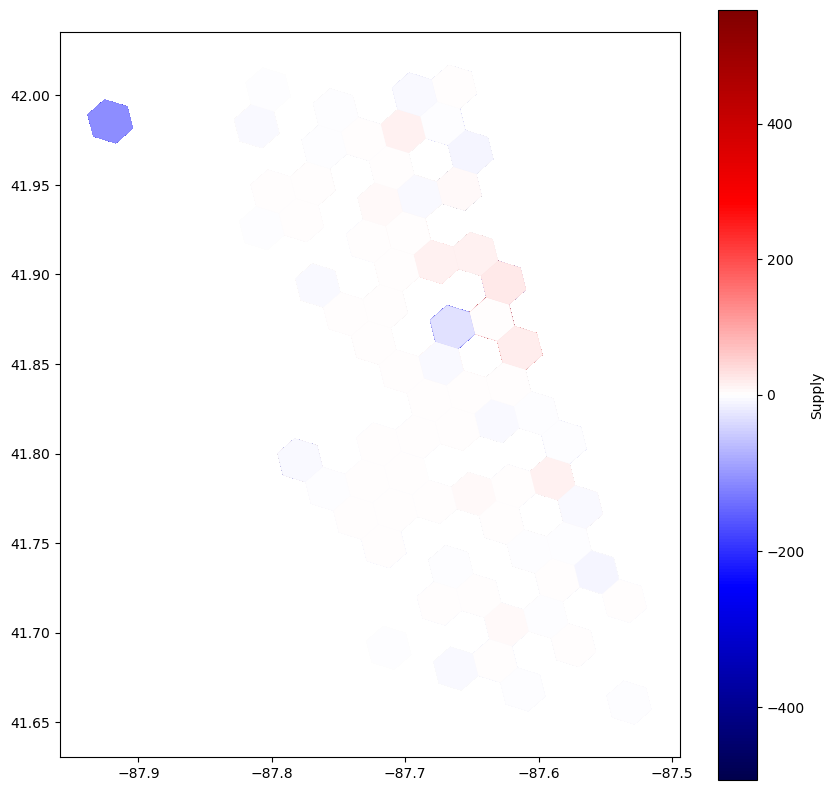

In [155]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 8], "trip_amount_balance", "Supply", True, color_scheme="seismic")

<AxesSubplot: >

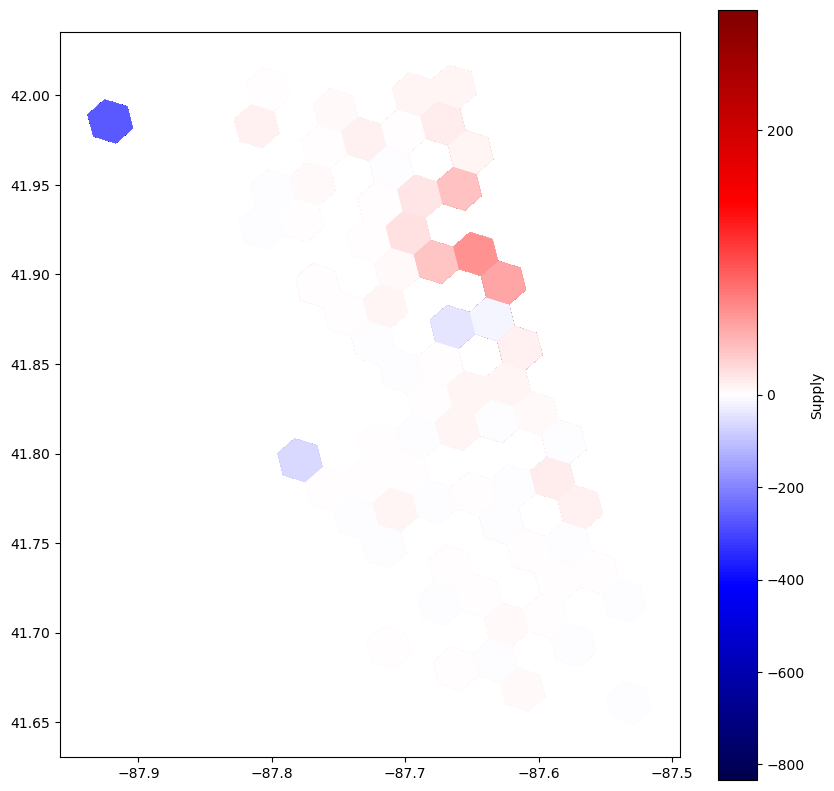

In [156]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 12], "trip_amount_balance", "Supply", True, color_scheme="seismic")

<AxesSubplot: >

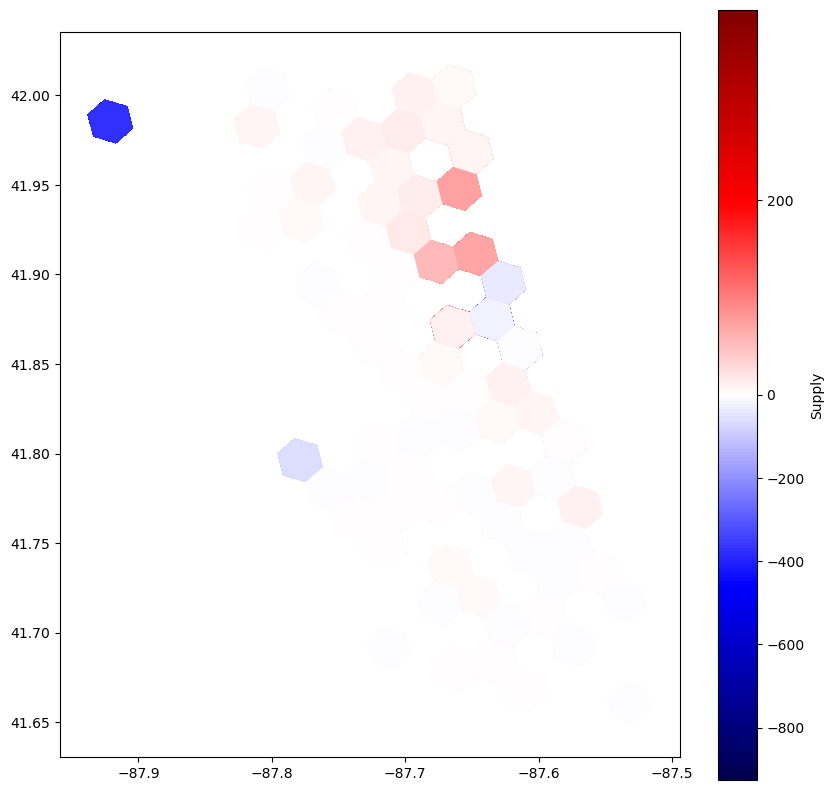

In [157]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 16], "trip_amount_balance", "Supply", True, color_scheme="seismic")

<AxesSubplot: >

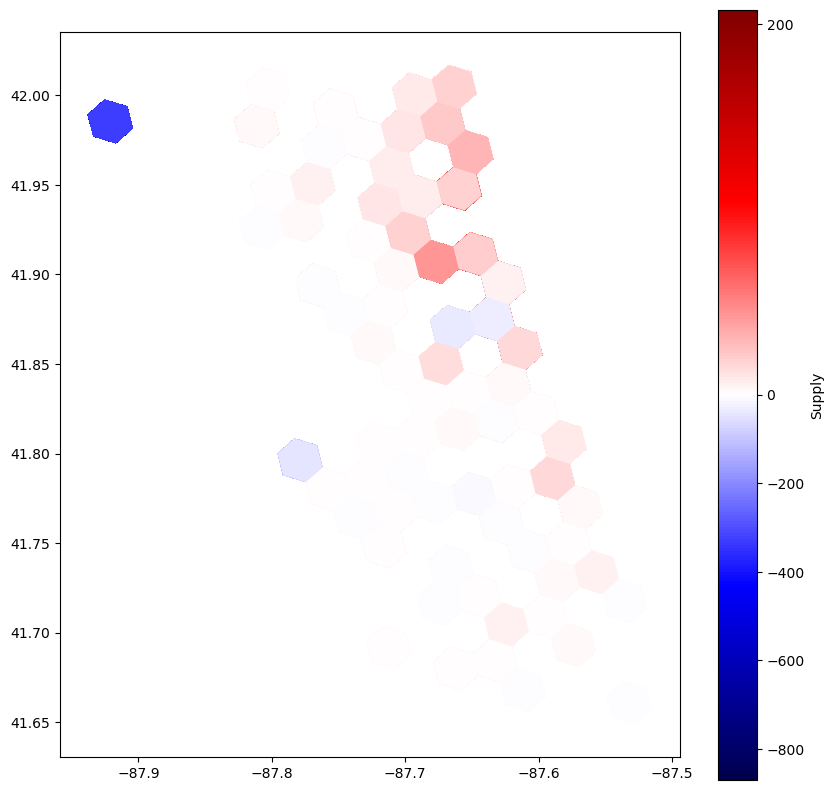

In [194]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 20], "trip_amount_balance", "Supply", True, color_scheme="seismic")